## Imports

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import pickle
from tqdm import tqdm
import gc
import catboost as cb
import xgboost as xgb
import re
import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import CrossEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
import json
import math
import os
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


## Load Data

In [3]:
# Konfigurasi Path
base_path = '/content/drive/MyDrive/gammafest25/'

train_file = base_path + 'train.csv'
test_file = base_path + 'test.csv'
metadata_file = base_path + 'papers_metadata.csv'
submission_file = base_path + 'sample_submission.csv'
paper_folder = base_path + 'Paper Database/'

try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    metadata_df = pd.read_csv(metadata_file)
    sample_submission_df = pd.read_csv(submission_file)
    print("Data loaded successfully!")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Metadata shape: {metadata_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Pastikan path file sudah benar dan file sudah diupload/tersedia.")

Data loaded successfully!
Train shape: (410691, 3)
Test shape: (336021, 3)
Metadata shape: (4354, 9)


## Merging dataset with metadata_df

### train_df

In [4]:
print("Merging metadata onto train_df...")
# Merge untuk paper_id (p1)
train_merged = pd.merge(train_df, metadata_df, left_on='paper', right_on='paper_id', how='left', suffixes=('', '_p1_meta'))
# Merge untuk referenced_paper_id (p2)
train_merged = pd.merge(train_merged, metadata_df, left_on='referenced_paper', right_on='paper_id', how='left', suffixes=('_p1', '_p2'))
# Drop kolom paper_id_p1 dan paper_id_p2 yang duplikat dari merge kedua
if 'paper_id_p1' in train_merged.columns:
    train_merged = train_merged.drop(columns=['paper_id_p1'])
if 'paper_id_p2' in train_merged.columns:
    train_merged = train_merged.drop(columns=['paper_id_p2'])


Merging metadata onto train_df...


In [5]:
print(f"Train merged shape: {train_merged.shape}")
train_merged.head()

Train merged shape: (410691, 19)


,paper,referenced_paper,is_referenced,doi_p1,title_p1,publication_year_p1,publication_date_p1,cited_by_count_p1,type_p1,authors_p1,concepts_p1,doi_p2,title_p2,publication_year_p2,publication_date_p2,cited_by_count_p2,type_p2,authors_p2,concepts_p2
0,p2128,p3728,0,https://doi.org/10.18653/v1/2021.findings-acl.84,A Survey of Data Augmentation Approaches for NLP,2021,1/1/2021,357,article,Steven Y. Feng; Varun Gangal; Jason Wei; Sarat...,Computer science; Popularity; Artificial intel...,https://doi.org/10.1137/16m1080173,Optimization Methods for Large-Scale Machine L...,2018,1/1/2018,2492,article,Léon Bottou; Frank E. Curtis; Jorge Nocedal,Computer science; Machine learning; Artificial...
1,p0389,p3811,0,https://doi.org/10.1016/b978-1-55860-377-6.500...,Residual Algorithms: Reinforcement Learning wi...,1995,1/1/1995,981,book-chapter,Leemon C. Baird,Residual; Algorithm; Reinforcement learning; C...,https://doi.org/10.1109/cvpr.2019.00447,Filter Pruning via Geometric Median for Deep C...,2019,6/1/2019,1078,article,Yang He; Ping Liu; Ziwei Wang; Zhilan Hu; Yi Yang,FLOPS; Computer science; Convolutional neural ...
2,p1298,p3760,0,https://doi.org/10.1109/tpami.2016.2644615,SegNet: A Deep Convolutional Encoder-Decoder A...,2017,1/2/2017,16255,article,Vijay Badrinarayanan; A. C. Kendall; Roberto C...,Computer science; Artificial intelligence; Ups...,https://doi.org/10.1002/pmic.201500396,Integrative methods for analyzing big data in ...,2015,12/17/2015,182,review,Vladimir Gligorijević; Noël Malod‐Dognin; Nata...,Big data; Data science; Precision medicine; Re...
3,p0211,p1808,0,https://doi.org/10.1109/tpami.2017.2699184,DeepLab: Semantic Image Segmentation with Deep...,2017,4/27/2017,18641,article,Liang-Chieh Chen; George Papandreou; Iasonas K...,Conditional random field; Artificial intellige...,https://doi.org/10.1609/aimag.v31i3.2303,Building Watson: An Overview of the DeepQA Pro...,2010,9/1/2010,1479,article,David Ferrucci; Eric W. Brown; Jennifer Chu‐Ca...,Watson; Champion; IBM; Computer science; Archi...
4,p0843,p2964,0,https://doi.org/10.1007/s11831-021-09694-4,Particle Swarm Optimization Algorithm and Its ...,2022,4/19/2022,799,review,Ahmed G. Gad,Particle swarm optimization; Swarm intelligenc...,https://doi.org/10.1007/bf00114723,Linear Least-Squares algorithms for temporal d...,1996,1/1/1996,645,article,Steven J. Bradtke; Andrew G. Barto,Recursive least squares filter; Algorithm; Tem...


### test_df

In [6]:
print("Merging metadata onto test_df...")
# Merge untuk paper_id (p1)
test_merged = pd.merge(test_df, metadata_df, left_on='paper', right_on='paper_id', how='left', suffixes=('', '_p1_meta'))
# Merge untuk referenced_paper_id (p2)
test_merged = pd.merge(test_merged, metadata_df, left_on='referenced_paper', right_on='paper_id', how='left', suffixes=('_p1', '_p2'))
# Drop kolom paper_id_p1 dan paper_id_p2 yang duplikat dari merge kedua
if 'paper_id_p1' in test_merged.columns:
    test_merged = test_merged.drop(columns=['paper_id_p1'])
if 'paper_id_p2' in test_merged.columns:
    test_merged = test_merged.drop(columns=['paper_id_p2'])

Merging metadata onto test_df...


In [7]:
print(f"test merged shape: {test_merged.shape}")
test_merged.head()

test merged shape: (336021, 19)


,id,paper,referenced_paper,doi_p1,title_p1,publication_year_p1,publication_date_p1,cited_by_count_p1,type_p1,authors_p1,concepts_p1,doi_p2,title_p2,publication_year_p2,publication_date_p2,cited_by_count_p2,type_p2,authors_p2,concepts_p2
0,0,p0913,p3488,https://doi.org/10.19173/irrodl.v11i1.769,Profiles in self-regulated learning in the onl...,2010,3/5/2010,401,article,Lucy Barnard‐Brak; Valerie Osland Paton; Willi...,Self-regulated learning; Likert scale; Psychol...,https://doi.org/10.19173/irrodl.v12i3.890,Three generations of distance education pedagogy,2011,3/25/2011,933,article,Terry Anderson; Jon Dron,Distance education; Pedagogy; Community of inq...
1,1,p2971,p4337,https://doi.org/10.1063/1.5136351,Feature engineering and symbolic regression me...,2020,1/1/2020,74,article,Harsha Vaddireddy; Adil Rasheed; Anne Staples;...,Physics; Statistical physics; Feature (linguis...,https://doi.org/10.3102/0013189x018001032,Situated Cognition and the Culture of Learning,1989,1/1/1989,12629,article,John Seely Brown; Allan Collins; Paul Duguid,Situated; Situated cognition; Cognitive appren...
2,2,p2237,p1610,https://doi.org/10.1371/journal.pcbi.1003919,Bayesian Inference of Sampled Ancestor Trees f...,2014,12/4/2014,349,article,Alexandra Gavryushkina; David Welch; Tanja Sta...,Ancestor; Phylogenetic tree; Inference; Markov...,https://doi.org/10.1163/2210-7975_hrd-9927-201...,The Millennium Development Goals Report,2018,8/17/2018,3729,dataset,NaN,Millennium Development Goals; Geography; Envir...
3,3,p2876,p3212,https://doi.org/10.1371/journal.pone.0225015,Towards implementation of AI in New Zealand na...,2020,4/10/2020,21,article,Li Xie; Song Yang; David Squirrell; Ehsan Vaghefi,Computer science; Convolutional neural network...,https://doi.org/10.1007/bfb0103798,Branching and interacting particle systems app...,2000,1/1/2000,274,book-chapter,Pierre Del Moral; Laurent Miclo,Mathematics; Feynman diagram; Particle system;...
4,4,p2939,p1901,https://doi.org/10.18653/v1/s16-1001,SemEval-2016 Task 4: Sentiment Analysis in Twi...,2016,1/1/2016,592,article,Preslav Nakov; Alan Ritter; Sara Rosenthal; Fa...,SemEval; Sentiment analysis; Computer science;...,https://doi.org/10.1109/icarcv.2006.345351,Decentralized Reinforcement Learning Control o...,2006,1/1/2006,51,article,Lucian Buşoniu; Bart De Schutter; Robert Babuška,Reinforcement learning; Variety (cybernetics);...


### metadata_df

In [8]:
metadata_df.head()

,paper_id,doi,title,publication_year,publication_date,cited_by_count,type,authors,concepts
0,p0000,https://doi.org/10.1161/circulationaha.115.001593,Machine Learning in Medicine,2015,11/16/2015,2662,review,Rahul C. Deo,Medicine; Medical physics; Medical education; ...
1,p0001,https://doi.org/10.1504/ijmmno.2013.055204,A literature survey of benchmark functions for...,2013,1/1/2013,1138,article,Momin Jamil; Xin‐She Yang,Benchmark (surveying); Set (abstract data type...
2,p0002,https://doi.org/10.1109/icip.2017.8296547,Abnormal event detection in videos using gener...,2017,9/1/2017,486,article,Mahdyar Ravanbakhsh; Moin Nabi; Enver Sanginet...,Abnormality; Computer science; Artificial inte...
3,p0003,https://doi.org/10.3115/v1/p15-1001,On Using Very Large Target Vocabulary for Neur...,2015,1/1/2015,916,article,Sébastien Jean; Kyunghyun Cho; Roland Memisevi...,Machine translation; Computer science; Vocabul...
4,p0004,https://doi.org/10.1109/tpami.2007.1167,Gaussian Process Dynamical Models for Human Mo...,2007,12/20/2007,1016,article,Jonathan M. Wang; David J. Fleet; Aaron Hertzmann,Gaussian process; Artificial intelligence; Lat...


## Data Preparation

### paper_df

In [9]:
def process_paper(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return content
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

paper_data = []

txt_files = [f for f in os.listdir(paper_folder) if f.endswith('.txt')]

for filename in tqdm(txt_files, desc="Processing papers"):
    file_path = os.path.join(paper_folder, filename)
    paper_content = process_paper(file_path)
    if paper_content:
        paper_data.append({'paper_id': filename[:-4], 'content': paper_content})

paper_df = pd.DataFrame(paper_data)
print(paper_df.head())
paper_df.to_parquet(f'{base_path}/paper_df.csv', index=False)

Processing papers: 0it [00:00, ?it/s]

Empty DataFrame
Columns: []
Index: []


In [10]:
paper_df = pd.read_parquet(f'{base_path}/paper_df.parquet')
paper_df.head(1)

,paper_id,content
0,p3360,Dynamical studies of transitions B y V. Dobros...


In [11]:
paper_df['content'][0]

"Dynamical studies of transitions B y V. Dobrosavljevi'c1 and Gabriel Kotliar2 1Department of Physics and National High Magnetic Field Laboratory, Florida State University, Tallahassee, Florida 32306, USA 2Serin Physics Laboratory, Rutgers University, PO Box 849, Piscataway, NJ 08855, USA We discuss the successes of the dynamical mean field (DMF) approach to metal insulator transitions in both the clean and the disordered limit. In the latter case, standard DMF equations are generalized in order to incorporate both the physics of strong correlation and Anderson localization eﬀects. The results give new insights into the puzzling features of doped semiconductors. 1. Introduction How a substance evolves from a metallic to a non metallic state is one of the most fundamental and richest problems in condensed matter physics. In general, there are several mechanisms at play. interactions can drive a metal to insulator transition in a pure substance. This transition is named after Sir Nevill 

In [12]:
def clean_paper_content(content):
    """
    Clean the messy content from academic papers with enhanced normalization,
    including mathematical equation removal.

    Args:
        content (str): Raw text content from the paper

    Returns:
        str: Cleaned and normalized text content
    """
    # 1. Mathematical equation removal (multiple patterns)
    # Remove inline equations between $ $ or \( \)
    content = re.sub(r'\$.*?\$', ' ', content)  # $...$ equations
    content = re.sub(r'\\\(.*?\\\)', ' ', content)  # \(...\) equations

    # Remove display equations between $$ $$ or \[ \]
    content = re.sub(r'\$\$.*?\$\$', ' ', content, flags=re.DOTALL)  # $$...$$ equations
    content = re.sub(r'\\\[.*?\\\]', ' ', content, flags=re.DOTALL)  # \[...\] equations

    # Remove equation environments \begin{equation}...\end{equation}
    content = re.sub(r'\\begin\{equation\}.*?\\end\{equation\}', ' ',
                    content, flags=re.DOTALL)

    # Remove simple mathematical expressions with common operators
    content = re.sub(r'\b[\w\d]+[+\-*/^=<>][\w\d]+\b', ' ', content)

    # 2. Unicode normalization
    content = content.replace('ﬁ', 'fi').replace('ﬂ', 'fl')
    content = content.replace('´', "'").replace('`', "'")  # Normalize apostrophes

    # 3. Dash/hyphen normalization
    content = re.sub(r'[−‐‑‒–—―]', '-', content)

    # 4. Line break handling
    content = re.sub(r'(?<!\n)\n(?!\n)', ' ', content)  # Remove mid-sentence breaks
    content = re.sub(r'\s*-\s*\n\s*', '', content)  # Handle hyphenated word breaks

    # 5. Whitespace normalization
    content = re.sub(r' +', ' ', content)
    content = re.sub(r'\n+', '\n', content)

    # 6. Remove citations and references
    content = re.sub(r'\[[0-9,]+\]', '', content)  # [1], [1,2], etc.
    content = re.sub(r'\([A-Za-z]+(?: et al\.)?,? \d{4}[a-z]?\)', '', content)  # (Author et al., 1999)

    # 7. Remove common LaTeX/PDF artifacts
    content = re.sub(r'\\[a-zA-Z]+\{.*?\}', ' ', content)  # \command{...}
    content = re.sub(r'\\[^a-zA-Z]', ' ', content)  # Single character commands

    # 8. Remove figure/table references
    content = re.sub(r'(?:Fig|Figure|Table)\s*[0-9IVX]+\.?', ' ', content, flags=re.IGNORECASE)

    # 9. Final cleanup
    content = content.strip()
    content = re.sub(r'\s+([.,;:!?])', r'\1', content)  # Fix space before punctuation

    return content

def clean_paper_dataframe(df, content_col='content'):
    """
    Apply enhanced cleaning function to a DataFrame column with progress tracking.

    Args:
        df (pd.DataFrame): DataFrame containing paper content
        content_col (str): Name of the column containing content to clean

    Returns:
        pd.DataFrame: DataFrame with cleaned content
    """
    tqdm.pandas(desc="Cleaning paper content")
    df[content_col] = df[content_col].progress_apply(clean_paper_content)
    return df

In [14]:
paper_df = clean_paper_dataframe(paper_df)

Cleaning paper content:   0%|          | 0/4354 [00:00<?, ?it/s]

In [ ]:
# paper_df.to_parquet(f'{base_path}/paper_df.parquet')
# paper_df = pd.read_parquet(f'{base_path}/paper_df.parquet').set_index('paper_id')

### Handling missing values

In [15]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410691 entries, 0 to 410690
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   paper                410691 non-null  object
 1   referenced_paper     410691 non-null  object
 2   is_referenced        410691 non-null  int64 
 3   doi_p1               408010 non-null  object
 4   title_p1             410691 non-null  object
 5   publication_year_p1  410691 non-null  int64 
 6   publication_date_p1  410691 non-null  object
 7   cited_by_count_p1    410691 non-null  int64 
 8   type_p1              410691 non-null  object
 9   authors_p1           410105 non-null  object
 10  concepts_p1          410691 non-null  object
 11  doi_p2               407460 non-null  object
 12  title_p2             405659 non-null  object
 13  publication_year_p2  410691 non-null  int64 
 14  publication_date_p2  410691 non-null  object
 15  cited_by_count_p2    410691 non-nu

- missing doi => impute with empty string
- missing title => impute with empty string
- missing authors => impute with empty string

In [16]:
# Untuk kolom teks yang akan dipakai: 'doi, title, authors'
for col in ['title_p1', 'title_p2', 'doi_p1', 'doi_p2', 'authors_p1', 'authors_p2']:
    train_merged[col] = train_merged[col].fillna("")
    test_merged[col] = test_merged[col].fillna("")
    print(f"Filled NaNs in {col} with empty string")

Filled NaNs in title_p1 with empty string
Filled NaNs in title_p2 with empty string
Filled NaNs in doi_p1 with empty string
Filled NaNs in doi_p2 with empty string
Filled NaNs in authors_p1 with empty string
Filled NaNs in authors_p2 with empty string


### Text Preprocessing

In [17]:
def drop_emoticon(df):
    # Iterate over the rows in the dataframe
    emoticon_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F900-\U0001F9FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F300-\U0001F5FF\U0001F900-\U0001F9FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F900-\U0001F9FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F300-\U0001F5FF\U0001F900-\U0001F9FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F300-\U0001F5FF\U0001F900-\U0001F9FF]+'

    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        output = re.sub(emoticon_pattern, '', value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def drop_miscellanous_unnecessary_char(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        # Define the mention pattern

        output = re.sub(r"(RT |https://t\.co/[A-Za-z0-9]+|\[.*?\])", "", value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def drop_mention(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        # Define the mention pattern
        mention_pattern = r'@[A-Za-z0-9+/=]+'

        output = re.sub(mention_pattern, '', value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def drop_link(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        # Define the mention pattern
        link_pattern = r'\s*https?://\S+$'

        output = re.sub(link_pattern, '', value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def remove_escape_sequences(text):
    # Remove escape sequences
    text = re.sub(r'\\\\', '', text)     # \\
    text = re.sub(r"\\'", "'", text)     # \'
    text = re.sub(r'\\"', '"', text)     # \"
    text = re.sub(r'\\n', '', text)      # \n
    text = re.sub(r'\n\n', '', text)
    text = re.sub(r'\\t', '', text)      # \t
    text = re.sub(r'\\b', '', text)      # \b
    text = re.sub(r'\\r', '', text)      # \r
    text = re.sub(r'\\f', '', text)      # \f
    text = re.sub(r'\\012', '', text)    # \012
    text = re.sub(r'\\x0A', '', text)    # \x0A

    return text

def remove_html_entities(text):
    # Remove HTML entities
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'&lt;', '', text)
    text = re.sub(r'&gt;', '', text)
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'&apos;', '', text)
    text = re.sub(r'&nbsp;', '', text)

    return text

def drop_escape_html_character(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        value = remove_escape_sequences(value)
        value = remove_html_entities(value)


        #print(output)
        # Change the value in place
        df.loc[i,"text"]= value

    return df

def drop_hashtags(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        # Define the mention pattern

        output = re.sub(r'#\w+', '', value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def lowercasing(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        output =  value.lower()

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def discard_non_ascii(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        # Define the mention pattern
        ascii_pattern = r'[^\x00-\x7F]+'

        output = re.sub(ascii_pattern, '', value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def remove_punctuation(sentence):
    # Create a translation table mapping punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Remove punctuation using the translation table
    sentence_without_punctuation = sentence.translate(translator)

    return sentence_without_punctuation


def drop_puctuation(df):
    for i in range(0,len(df['text'])):
        # Perform the desired manipulation

        value = str(df['text'][i])

        output =  remove_punctuation(value)

        #print(output)
        # Change the value in place
        df.loc[i,"text"]= output

    return df

def drop_stopwords_english(df, text_col='text', keep_negation=True):
    """
    Remove English stopwords from the specified text column of a DataFrame.

    Args:
        df           : pandas.DataFrame with a column of strings.
        text_col     : name of the column containing text.
        keep_negation: whether to keep the word 'not' (so negations aren't lost).

    Returns:
        df with the same text column stripped of stopwords.
    """
    # Load English stopwords
    stop_words = set(stopwords.words('english'))
    # Optionally keep negation
    if keep_negation and 'not' in stop_words:
        stop_words.remove('not')

    # Define a helper to clean a single sentence
    def _filter_sentence(sent: str) -> str:
        words = sent.split()
        filtered = [w for w in words if w.lower() not in stop_words]
        return ' '.join(filtered)

    # Apply to the entire column
    df[text_col] = df[text_col].astype(str).apply(_filter_sentence)
    return df

def stemming_english(df, text_col='text'):
    """
    Stem English text in a DataFrame column.

    Args:
        df       : pandas.DataFrame containing the text.
        text_col : name of the column with the raw text.

    Returns:
        The same DataFrame with the specified column stemmed.
    """
    stemmer = SnowballStemmer('english')

    def _stem_sentence(sent: str) -> str:
        tokens = word_tokenize(sent)
        stems = [stemmer.stem(tok) for tok in tokens]
        return ' '.join(stems)

    # Apply stemming
    df[text_col] = df[text_col].astype(str).apply(_stem_sentence)
    return df

def truncate_text(df, text_col='text', n=10000):
    """
    Truncate text in the specified column to only the first n words.

    Args:
        df       : pandas.DataFrame containing the text.
        text_col : name of the column to process.
        n        : maximum number of words to keep.

    Returns:
        DataFrame with the text truncated to the first n words.
    """
    def take_first_n(sentence):
        words = sentence.split()
        return " ".join(words[:n])

    df[text_col] = df[text_col].astype(str).apply(take_first_n)
    return df




# ——— PIPELINE CONFIGURATION ———
# Comment out any step you don't want.
PIPELINE = [
    truncate_text,
    drop_emoticon,
    drop_miscellanous_unnecessary_char,
    drop_mention,
    drop_link,
    drop_escape_html_character,
    drop_hashtags,
    lowercasing,
    discard_non_ascii,
    drop_puctuation,
    drop_stopwords_english,
    stemming_english
]


def preprocess_file(input_path: str, output_path: str, pipeline):
    """
    Reads a single .txt file as one document, applies pipeline steps,
    and writes cleaned text to output_path.
    """
    # Read entire paper as one string
    with open(input_path, 'r', encoding='utf-8') as f:
        content = f.read()
    # Wrap into DataFrame
    df = pd.DataFrame({'text': [content]})
    # Apply each preprocessing function, with progress
    for func in pipeline:
        df = func(df)
    # Extract cleaned text
    cleaned = df.at[0, 'text']
    # Write back out
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(cleaned)


def run_text_preprocessing_pipeline(input_dir: str, output_dir: str, pipeline):
    """
    Applies the pipeline to every .txt in input_dir,
    saving results in output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    # Gather .txt files
    txt_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.txt')]
    # Iterate with progress bar
    for fname in tqdm(txt_files, desc='Processing files'):
        in_path  = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)
        preprocess_file(in_path, out_path, pipeline)
    print(f"→ Completed {len(txt_files)} files.")




In [18]:
raw_text_path = '/paper_database'
interim_text_path = '/paper_database_processed_cap_10000'

# Karena keterbatasan resource, kode dijalankan secara terpisah
# run_text_preprocessing_pipeline(raw_text_path, interim_text_path, PIPELINE)

## Feature Engineering



Catatan: Karena keterbatasan resource, maka kode pada bagian ini dijalankan pada runtime yang terpisah, dan hasilnya akan diload pada notebook ini.

### Fitur: days_diff + months_diff + year_diff

fitur selisih hari, bulan, dan tahun antara paper dengan referenced_paper

In [ ]:
# Convert 'publication_date' columns to datetime objects
train_merged['publication_date_p1'] = pd.to_datetime(train_merged['publication_date_p1'], errors='coerce')
train_merged['publication_date_p2'] = pd.to_datetime(train_merged['publication_date_p2'], errors='coerce')
test_merged['publication_date_p1'] = pd.to_datetime(test_merged['publication_date_p1'], errors='coerce')
test_merged['publication_date_p2'] = pd.to_datetime(test_merged['publication_date_p2'], errors='coerce')

# Calculate the difference in days and months
train_merged['days_diff'] = (train_merged['publication_date_p1'] - train_merged['publication_date_p2']).dt.days
train_merged['months_diff'] = (train_merged['publication_date_p1'] - train_merged['publication_date_p2']).dt.days // 30
test_merged['days_diff'] = (test_merged['publication_date_p1'] - test_merged['publication_date_p2']).dt.days
test_merged['months_diff'] = (test_merged['publication_date_p1'] - test_merged['publication_date_p2']).dt.days // 30

# Fill NaN values with 0 (you might consider other imputation strategies)
train_merged['days_diff'] = train_merged['days_diff'].fillna(0).astype(int)
train_merged['months_diff'] = train_merged['months_diff'].fillna(0).astype(int)
test_merged['days_diff'] = test_merged['days_diff'].fillna(0).astype(int)
test_merged['months_diff'] = test_merged['months_diff'].fillna(0).astype(int)

In [ ]:
train_merged['year_diff'] = train_merged['publication_year_p1'] - train_merged['publication_year_p2']
test_merged['year_diff'] = test_merged['publication_year_p1'] - test_merged['publication_year_p2']
print("Created 'year_diff' feature.")
train_merged.head()

Created 'year_diff' feature.


,paper,referenced_paper,is_referenced,doi_p1,title_p1,publication_year_p1,publication_date_p1,cited_by_count_p1,type_p1,authors_p1,concepts_p1,doi_p2,title_p2,publication_year_p2,publication_date_p2,cited_by_count_p2,type_p2,authors_p2,concepts_p2,year_diff
0,p2128,p3728,0,https://doi.org/10.18653/v1/2021.findings-acl.84,A Survey of Data Augmentation Approaches for NLP,2021,1/1/2021,357,article,Steven Y. Feng; Varun Gangal; Jason Wei; Sarat...,Computer science; Popularity; Artificial intel...,https://doi.org/10.1137/16m1080173,Optimization Methods for Large-Scale Machine L...,2018,1/1/2018,2492,article,Léon Bottou; Frank E. Curtis; Jorge Nocedal,Computer science; Machine learning; Artificial...,3
1,p0389,p3811,0,https://doi.org/10.1016/b978-1-55860-377-6.500...,Residual Algorithms: Reinforcement Learning wi...,1995,1/1/1995,981,book-chapter,Leemon C. Baird,Residual; Algorithm; Reinforcement learning; C...,https://doi.org/10.1109/cvpr.2019.00447,Filter Pruning via Geometric Median for Deep C...,2019,6/1/2019,1078,article,Yang He; Ping Liu; Ziwei Wang; Zhilan Hu; Yi Yang,FLOPS; Computer science; Convolutional neural ...,-24
2,p1298,p3760,0,https://doi.org/10.1109/tpami.2016.2644615,SegNet: A Deep Convolutional Encoder-Decoder A...,2017,1/2/2017,16255,article,Vijay Badrinarayanan; A. C. Kendall; Roberto C...,Computer science; Artificial intelligence; Ups...,https://doi.org/10.1002/pmic.201500396,Integrative methods for analyzing big data in ...,2015,12/17/2015,182,review,Vladimir Gligorijević; Noël Malod‐Dognin; Nata...,Big data; Data science; Precision medicine; Re...,2
3,p0211,p1808,0,https://doi.org/10.1109/tpami.2017.2699184,DeepLab: Semantic Image Segmentation with Deep...,2017,4/27/2017,18641,article,Liang-Chieh Chen; George Papandreou; Iasonas K...,Conditional random field; Artificial intellige...,https://doi.org/10.1609/aimag.v31i3.2303,Building Watson: An Overview of the DeepQA Pro...,2010,9/1/2010,1479,article,David Ferrucci; Eric W. Brown; Jennifer Chu‐Ca...,Watson; Champion; IBM; Computer science; Archi...,7
4,p0843,p2964,0,https://doi.org/10.1007/s11831-021-09694-4,Particle Swarm Optimization Algorithm and Its ...,2022,4/19/2022,799,review,Ahmed G. Gad,Particle swarm optimization; Swarm intelligenc...,https://doi.org/10.1007/bf00114723,Linear Least-Squares algorithms for temporal d...,1996,1/1/1996,645,article,Steven J. Bradtke; Andrew G. Barto,Recursive least squares filter; Algorithm; Tem...,26


### Fitur: TF-IDF Cosine Similarity pada Judul

menghitung kemiripan judul paper dengan referenced_paper menggunakan TF-IDF Cosine Similarity

In [ ]:
# Gabungkan semua judul unik dari train dan test untuk vocabulary TF-IDF
all_titles = pd.concat([train_merged['title_p1'], train_merged['title_p2'],
                        test_merged['title_p1'], test_merged['title_p2']]).astype(str).unique()

# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000) # Sesuaikan max_features

# Fit vectorizer pada semua judul unik
vectorizer.fit(all_titles)
print(f"TF-IDF Vectorizer fitted with vocabulary size: {len(vectorizer.vocabulary_)}")

# Transform judul p1 dan p2 untuk train dan test
tfidf_p1_train = vectorizer.transform(train_merged['title_p1'])
tfidf_p2_train = vectorizer.transform(train_merged['title_p2'])
tfidf_p1_test = vectorizer.transform(test_merged['title_p1'])
tfidf_p2_test = vectorizer.transform(test_merged['title_p2'])

# menghitung cosine similarity baris per baris
def calculate_cosine_similarity_rowwise(matrix1, matrix2):
    similarities = np.zeros(matrix1.shape[0])
    for i in range(matrix1.shape[0]):
        vec1 = matrix1[i]
        vec2 = matrix2[i]
        sim = cosine_similarity(vec1, vec2)[0, 0]
        similarities[i] = sim
        if (i + 1) % 50000 == 0:
            print(f"Processed {i+1} rows for cosine similarity...")
    return similarities

TF-IDF Vectorizer fitted with vocabulary size: 5459


In [ ]:
# Hitung similarity untuk train dan test
print("Calculating title cosine similarity for train set...")
train_merged['title_similarity'] = calculate_cosine_similarity_rowwise(tfidf_p1_train, tfidf_p2_train)
print("Calculating title cosine similarity for test set...")
test_merged['title_similarity'] = calculate_cosine_similarity_rowwise(tfidf_p1_test, tfidf_p2_test)

print("Created 'title_similarity' feature.")
print("\n--- Train Merged Head with New Features ---")
print(train_merged[['year_diff', 'cited_by_count_p2', 'title_similarity', 'is_referenced']].head())

# Hapus variabel TF-IDF besar untuk memori
del tfidf_p1_train, tfidf_p2_train, tfidf_p1_test, tfidf_p2_test, all_titles
gc.collect()

Calculating title cosine similarity for train set...
Processed 50000 rows for cosine similarity...
Processed 100000 rows for cosine similarity...
Processed 150000 rows for cosine similarity...
Processed 200000 rows for cosine similarity...
Processed 250000 rows for cosine similarity...
Processed 300000 rows for cosine similarity...
Processed 350000 rows for cosine similarity...
Processed 400000 rows for cosine similarity...
Calculating title cosine similarity for test set...
Processed 50000 rows for cosine similarity...
Processed 100000 rows for cosine similarity...
Processed 150000 rows for cosine similarity...
Processed 200000 rows for cosine similarity...
Processed 250000 rows for cosine similarity...
Processed 300000 rows for cosine similarity...
Created 'title_similarity' feature.

--- Train Merged Head with New Features ---
   year_diff  cited_by_count_p2  title_similarity  is_referenced
0          3               2492               0.0              0
1        -24               1

80011

### Fitur: concepts_overlap_count & concepts_jaccard

menghitung berapa jumlah concepts yang overlap antara kedua paper, serta menghitung similaritas menggunakan jaccard similarity

In [ ]:
print("\nCalculating Concept Similarity Features...")

def calculate_concept_features(concepts1_str, concepts2_str):
    try:
        # Proses string konsep 1
        if pd.isna(concepts1_str) or concepts1_str == "":
            set1 = set()
        else:
            set1 = set(c.strip().lower() for c in concepts1_str.split(';') if c.strip())

        # Proses string konsep 2
        if pd.isna(concepts2_str) or concepts2_str == "":
            set2 = set()
        else:
            set2 = set(c.strip().lower() for c in concepts2_str.split(';') if c.strip())

        # Hitung Intersection dan Union
        intersection_count = len(set1.intersection(set2))
        union_count = len(set1.union(set2))

        # Hitung Jaccard Similarity
        if union_count == 0:
            # Jika kedua set kosong, Jaccard bisa dianggap 0 atau 1. 0 lebih aman.
            jaccard_similarity = 0.0
        else:
            jaccard_similarity = intersection_count / union_count

        # Kembalikan hasil sebagai Pandas Series agar mudah diassign ke kolom baru
        return pd.Series([intersection_count, jaccard_similarity])

    except Exception as e:
        print(f"Error processing concepts: '{concepts1_str}' vs '{concepts2_str}'. Error: {e}")
        return pd.Series([0, 0.0])


# Terapkan fungsi ke DataFrame train dan test
print("Applying concept feature calculation to train_merged...")
train_merged[['concepts_overlap_count', 'concepts_jaccard']] = train_merged.apply(
    lambda row: calculate_concept_features(row.get('concepts_p1', ''), row.get('concepts_p2', '')),
    axis=1
)

print("Applying concept feature calculation to test_merged...")
test_merged[['concepts_overlap_count', 'concepts_jaccard']] = test_merged.apply(
    lambda row: calculate_concept_features(row.get('concepts_p1', ''), row.get('concepts_p2', '')),
    axis=1
)

print("Created 'concepts_overlap_count' and 'concepts_jaccard' features.")

print("\n--- Train Merged Head with New Concept Features ---")
print(train_merged[['year_diff', 'cited_by_count_p2', 'title_similarity',
                 'concepts_overlap_count', 'concepts_jaccard', 'is_referenced']].head())

print("\n--- Describe New Concept Features (Train) ---")
print(train_merged[['concepts_overlap_count', 'concepts_jaccard']].describe())

# Cek missing values pada fitur baru (seharusnya tidak ada)
print("\nMissing values in new concept features (Train):")
print(train_merged[['concepts_overlap_count', 'concepts_jaccard']].isnull().sum())
print("\nMissing values in new concept features (Test):")
print(test_merged[['concepts_overlap_count', 'concepts_jaccard']].isnull().sum())


Calculating Concept Similarity Features...
Applying concept feature calculation to train_merged...
Applying concept feature calculation to test_merged...
Created 'concepts_overlap_count' and 'concepts_jaccard' features.

--- Train Merged Head with New Concept Features ---
   year_diff  cited_by_count_p2  title_similarity  concepts_overlap_count  \
0          3               2492               0.0                     2.0   
1        -24               1078               0.0                     0.0   
2          2                182               0.0                     1.0   
3          7               1479               0.0                     1.0   
4         26                645               0.0                     0.0   

   concepts_jaccard  is_referenced  
0          0.250000              0  
1          0.000000              0  
2          0.111111              0  
3          0.111111              0  
4          0.000000              0  

--- Describe New Concept Features (Train

### Fitur: authors_overlap_count & authors_jaccard

menghitung berapa jumlah authors yang overlap antara kedua paper, serta menghitung similaritas menggunakan jaccard similarity

In [ ]:
print("\nCalculating Author Similarity Features...")

def calculate_author_features(authors1_str, authors2_str):
    try:
        # Proses string penulis 1
        if pd.isna(authors1_str) or authors1_str == "":
            set1 = set()
        else:
            set1 = set(a.strip().lower() for a in authors1_str.split(';') if a.strip())

        # Proses string penulis 2
        if pd.isna(authors2_str) or authors2_str == "":
            set2 = set()
        else:
            set2 = set(a.strip().lower() for a in authors2_str.split(';') if a.strip())

        # Hitung Intersection dan Union
        intersection_count = len(set1.intersection(set2))
        union_count = len(set1.union(set2))

        # Hitung Jaccard Similarity
        if union_count == 0:
            jaccard_similarity = 0.0
        else:
            jaccard_similarity = intersection_count / union_count

        return pd.Series([intersection_count, jaccard_similarity])

    except Exception as e:
        print(f"Error processing authors: '{authors1_str}' vs '{authors2_str}'. Error: {e}")
        return pd.Series([0, 0.0]) # Default


# Terapkan fungsi ke DataFrame train dan test
print("Applying author feature calculation to train_merged...")
train_merged[['authors_overlap_count', 'authors_jaccard']] = train_merged.apply(
    lambda row: calculate_author_features(row.get('authors_p1', ''), row.get('authors_p2', '')),
    axis=1
)

print("Applying author feature calculation to test_merged...")
test_merged[['authors_overlap_count', 'authors_jaccard']] = test_merged.apply(
    lambda row: calculate_author_features(row.get('authors_p1', ''), row.get('authors_p2', '')),
    axis=1
)

print("Created 'authors_overlap_count' and 'authors_jaccard' features.")


print("\n--- Describe New Author Features (Train) ---")
if 'authors_overlap_count' in train_merged.columns:
    print(train_merged[['authors_overlap_count', 'authors_jaccard']].describe())

# Cek missing values pada fitur baru (seharusnya tidak ada)
print("\nMissing values in new author features (Train):")
if 'authors_overlap_count' in train_merged.columns:
    print(train_merged[['authors_overlap_count', 'authors_jaccard']].isnull().sum())
print("\nMissing values in new author features (Test):")
if 'authors_overlap_count' in test_merged.columns:
    print(test_merged[['authors_overlap_count', 'authors_jaccard']].isnull().sum())


Calculating Author Similarity Features...
Applying author feature calculation to train_merged...
Applying author feature calculation to test_merged...
Created 'authors_overlap_count' and 'authors_jaccard' features.

--- Train Merged Head with New Author Features ---
   year_diff  cited_by_count_p2  title_similarity  concepts_overlap_count  \
0          3               2492               0.0                     2.0   
1        -24               1078               0.0                     0.0   
2          2                182               0.0                     1.0   
3          7               1479               0.0                     1.0   
4         26                645               0.0                     0.0   

   concepts_jaccard  authors_overlap_count  authors_jaccard  is_referenced  
0          0.250000                    0.0              0.0              0  
1          0.000000                    0.0              0.0              0  
2          0.111111                   

### Fitur-fitur: Authors Citation & Paper Score

membuat fitur-fitur yang berusaha membuat sinyal dari jumlah sitasi author-author paper dan referenced_paper, menggunakan statistics seperti mean, max, diff, dan ratio

In [ ]:
print("Starting Author Citation Statistics Preprocessing...")

metadata_authors_df = metadata_df[['paper_id', 'authors', 'cited_by_count']].copy()
metadata_authors_df['authors'] = metadata_authors_df['authors'].fillna("")
median_cited_count = metadata_authors_df['cited_by_count'].median()
metadata_authors_df['cited_by_count'] = metadata_authors_df['cited_by_count'].fillna(0)
print(f"Filled NaN cited_by_count with 0.")


# Fungsi untuk split, clean, dan lowercase
def clean_split_authors(authors_str):
    if pd.isna(authors_str) or authors_str == "":
        return []
    return [a.strip().lower() for a in authors_str.split(';') if a.strip()]

metadata_authors_df['author_list'] = metadata_authors_df['authors'].apply(clean_split_authors)

metadata_exploded = metadata_authors_df.explode('author_list')
metadata_exploded = metadata_exploded[metadata_exploded['author_list'] != '']
metadata_exploded = metadata_exploded.rename(columns={'author_list': 'author_name'})
print(f"Exploded metadata shape: {metadata_exploded.shape}")


# Hitung Statistik Agregat per Penulis Unik
print("Calculating aggregate statistics per author...")
author_stats = metadata_exploded.groupby('author_name')['cited_by_count'].agg(
    total_citations = 'sum',
    mean_citations = 'mean',
    max_citations = 'max',
    paper_count = 'count'
).reset_index()

print(f"Calculated stats for {author_stats.shape[0]} unique authors.")
print("Author stats sample:")
print(author_stats.sort_values(by='total_citations', ascending=False).head())


author_stats_dict = author_stats.set_index('author_name').to_dict('index')
print("Created author_stats_dict for quick lookup.")

del metadata_authors_df, metadata_exploded, author_stats
gc.collect()

Starting Author Citation Statistics Preprocessing...
Filled NaN cited_by_count with 0.
Exploded metadata shape: (14718, 4)
Calculating aggregate statistics per author...
Calculated stats for 10429 unique authors.
Author stats sample:
          author_name  total_citations  mean_citations  max_citations  \
7707    ross girshick           205965     7921.730769          44209   
4714       kaiming he           185842     6637.214286          44209   
9210   virginia braun           138239   138239.000000         138239   
9160  victoria clarke           138239   138239.000000         138239   
5175      leo breiman           117960    58980.000000         101861   

      paper_count  
7707           26  
4714           28  
9210            1  
9160            1  
5175            2  
Created author_stats_dict for quick lookup.


0

In [ ]:
print("\nCalculating Author Citation Score Features...")

# Pastikan dictionary statistik penulis sudah dibuat di cell sebelumnya
if 'author_stats_dict' not in locals() and 'author_stats_dict' not in globals():
     raise NameError("Variable 'author_stats_dict' not defined. Please run the author stats preprocessing cell first.")

# Fungsi helper untuk mendapatkan statistik agregat penulis untuk sebuah paper
def get_aggregated_author_stats(authors_str, author_stats_lookup, agg_methods=['mean', 'max', 'sum']):
    try:
        if pd.isna(authors_str) or authors_str == "":
            author_list = []
        else:
            author_list = [a.strip().lower() for a in authors_str.split(';') if a.strip()]

        # Kumpulkan statistik untuk setiap penulis di paper ini
        author_metrics = {'total_citations': [], 'mean_citations': [], 'max_citations': [], 'paper_count': []}
        found_authors = 0
        for author in author_list:
            stats = author_stats_lookup.get(author) # Lookup ke dict
            if stats:
                 found_authors += 1
                 author_metrics['total_citations'].append(stats.get('total_citations', 0))
                 author_metrics['mean_citations'].append(stats.get('mean_citations', 0))
                 author_metrics['max_citations'].append(stats.get('max_citations', 0))
                 author_metrics['paper_count'].append(stats.get('paper_count', 0))

        # Jika tidak ada penulis yang ditemukan atau tidak ada penulis sama sekali
        if not author_list or found_authors == 0:
            return pd.Series([0.0] * (len(author_metrics) * len(agg_methods)))


        # Hitung agregat (mean, max, sum) dari statistik penulis
        results = []
        for stat_name, values in author_metrics.items():
             if not values:
                 for method in agg_methods: results.append(0.0)
                 continue

             if 'mean' in agg_methods:
                 results.append(np.mean(values) if values else 0.0)
             if 'max' in agg_methods:
                 results.append(np.max(values) if values else 0.0)
             if 'sum' in agg_methods:
                 results.append(np.sum(values) if values else 0.0)

        return pd.Series(results)

    except Exception as e:
        print(f"Error processing author stats for: '{authors_str}'. Error: {e}")
        return pd.Series([0.0] * (4 * len(agg_methods)))


# Tentukan metode agregasi yang diinginkan
aggregation_methods = ['mean', 'max', 'sum']
new_author_stat_cols = []
for stat in ['total_citations', 'mean_citations', 'max_citations', 'paper_count']:
     for method in aggregation_methods:
         new_author_stat_cols.append(f"{method}_{stat}")

# Terapkan fungsi untuk p1 dan p2
print("Applying author citation stats calculation to train_merged...")
train_merged[[f"{col}_p1" for col in new_author_stat_cols]] = train_merged.apply(
    lambda row: get_aggregated_author_stats(row.get('authors_p1', ''), author_stats_dict, aggregation_methods),
    axis=1
)
train_merged[[f"{col}_p2" for col in new_author_stat_cols]] = train_merged.apply(
    lambda row: get_aggregated_author_stats(row.get('authors_p2', ''), author_stats_dict, aggregation_methods),
    axis=1
)

print("Applying author citation stats calculation to test_merged...")
test_merged[[f"{col}_p1" for col in new_author_stat_cols]] = test_merged.apply(
    lambda row: get_aggregated_author_stats(row.get('authors_p1', ''), author_stats_dict, aggregation_methods),
    axis=1
)
test_merged[[f"{col}_p2" for col in new_author_stat_cols]] = test_merged.apply(
    lambda row: get_aggregated_author_stats(row.get('authors_p2', ''), author_stats_dict, aggregation_methods),
    axis=1
)

print(f"Created {len(new_author_stat_cols)*2} new author citation score features.")


#  Buat Fitur Perbandingan (Difference/Ratio)
print("Creating comparison features for author citation scores...")
comparison_features_created = []
for col_base in new_author_stat_cols:
     col_p1 = f"{col_base}_p1"
     col_p2 = f"{col_base}_p2"
     diff_col = f"diff_{col_base}"
     ratio_col = f"ratio_{col_base}"

     # Hitung Difference
     train_merged[diff_col] = train_merged[col_p1] - train_merged[col_p2]
     test_merged[diff_col] = test_merged[col_p1] - test_merged[col_p2]
     comparison_features_created.append(diff_col)

     # Hitung Ratio (handle division by zero)
     train_merged[ratio_col] = train_merged[col_p1] / (train_merged[col_p2] + 1e-6)
     test_merged[ratio_col] = test_merged[col_p1] / (test_merged[col_p2] + 1e-6)

     train_merged[ratio_col] = train_merged[ratio_col].replace([np.inf, -np.inf], 0).fillna(0)
     test_merged[ratio_col] = test_merged[ratio_col].replace([np.inf, -np.inf], 0).fillna(0)
     comparison_features_created.append(ratio_col)

print(f"Created {len(comparison_features_created)} comparison features for author scores.")


# Tampilkan Hasil
print("\n--- Train Merged Head showing some new Author Citation Score Features ---")
# Tampilkan beberapa contoh fitur baru
cols_to_show = ['mean_total_citations_p1', 'mean_total_citations_p2',
                'max_total_citations_p1', 'max_total_citations_p2',
                'diff_mean_total_citations', 'ratio_mean_total_citations',
                'is_referenced']
existing_cols_to_show = [f for f in cols_to_show if f in train_merged.columns]
print(train_merged[existing_cols_to_show].head())

print("\n--- Describe some new Author Citation Score Features (Train) ---")
cols_to_describe = ['mean_total_citations_p1', 'max_total_citations_p1', 'diff_mean_total_citations', 'ratio_mean_total_citations']
existing_cols_to_describe = [f for f in cols_to_describe if f in train_merged.columns]
if existing_cols_to_describe:
    print(train_merged[existing_cols_to_describe].describe())

print("\nChecking NaNs in a sample of new author citation score features...")
cols_to_check_nan = [f"{col}_p1" for col in new_author_stat_cols[:2]] + \
                    [f"{col}_p2" for col in new_author_stat_cols[:2]] + \
                    comparison_features_created[:2]
existing_cols_to_check_nan = [f for f in cols_to_check_nan if f in train_merged.columns]
if existing_cols_to_check_nan:
     print("Train:\n", train_merged[existing_cols_to_check_nan].isnull().sum())
     print("\nTest:\n", test_merged[existing_cols_to_check_nan].isnull().sum())


Calculating Author Citation Score Features...
Applying author citation stats calculation to train_merged...
Applying author citation stats calculation to test_merged...
Created 24 new author citation score features.
Creating comparison features for author citation scores...
Created 24 comparison features for author scores.

--- Train Merged Head showing some new Author Citation Score Features ---
   mean_total_citations_p1  mean_total_citations_p2  max_total_citations_p1  \
0               676.600000                  27744.0                  1955.0   
1               981.000000                   3476.6                   981.0   
2             16877.666667                    182.0                 17325.0   
3             34921.600000                   1479.0                 58681.0   
4               799.000000                    843.0                   799.0   

   max_total_citations_p2  diff_mean_total_citations  \
0                 65209.0              -27067.400000   
1           

In [ ]:
aggregation_methods_used = ['mean', 'max', 'sum']
base_stats_used = ['total_citations', 'mean_citations', 'max_citations', 'paper_count']
author_stat_cols_bases = []
for stat in base_stats_used:
     for method in aggregation_methods_used:
         author_stat_cols_bases.append(f"{method}_{stat}")

author_stat_features_p1 = [f"{col}_p1" for col in author_stat_cols_bases]
author_stat_features_p2 = [f"{col}_p2" for col in author_stat_cols_bases]
author_stat_features_comp = []
for col_base in author_stat_cols_bases:
     author_stat_features_comp.append(f"diff_{col_base}")
     author_stat_features_comp.append(f"ratio_{col_base}")

### Fitur: matched_words_count

menghitung berapa banyak jumlah kata yang sama untuk pasangan paper dan referenced_paper

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def unique_words_excluding_stopwords(text):
  if pd.isna(text) or text == '':
    return []
  words = text.lower().split()
  unique_words = []
  for word in words:
    if word not in stop_words and word not in unique_words:
      unique_words.append(word)
  return unique_words

tqdm.pandas(desc="Extracting unique words")
paper_df['unique_words'] = paper_df['content'].progress_apply(unique_words_excluding_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Extracting unique words: 100%|██████████| 4354/4354 [05:21<00:00, 13.56it/s]


In [ ]:
def count_matched_words(row, paper_df):
    paper_words = set(paper_df.loc[paper_df['paper_id'] == row['paper'], 'unique_words'].iloc[0])
    ref_paper_words = set(paper_df.loc[paper_df['paper_id'] == row['referenced_paper'], 'unique_words'].iloc[0])
    return len(paper_words.intersection(ref_paper_words))

tqdm.pandas(desc="Counting matched words in train")
train_merged['matched_words_count'] = train_merged.progress_apply(lambda row: count_matched_words(row, paper_df), axis=1)

tqdm.pandas(desc="Counting matched words in test")
test_merged['matched_words_count'] = test_merged.progress_apply(lambda row: count_matched_words(row, paper_df), axis=1)

Counting matched words in test: 100%|██████████| 336021/336021 [12:27<00:00, 449.73it/s]


### Fitur: TITLE-TinyBERT-L6-score

menggunakan cross-encoder TinyBERT-L6 untuk mendapatkan skor "retreival" dari pasangan judul paper dan referenced_paper

In [ ]:
torch.multiprocessing.set_start_method('spawn', force=True)

# Initialize the Cross-Encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L6', device='cuda')

def get_title_cross_encoder_score(row):
    try:
        query = row['title_p1'] if row['title_p1'] is not None else ""
        passage = row['title_p2'] if row['title_p2'] is not None else ""
        score = cross_encoder.predict([[query, passage]])[0]
        return score
    except IndexError:
        return 0


tqdm.pandas(desc="Calculating TITLE-TinyBERT-L6 Score for Train")
train_merged['TITLE-TinyBERT-L6-score'] = train_merged.progress_apply(
    lambda row: get_title_cross_encoder_score(row), axis=1
)

tqdm.pandas(desc="Calculating TinyBERT-L6 Score for Test")
test_merged['TITLE-TinyBERT-L6-score'] = test_merged.progress_apply(
    lambda row: get_title_cross_encoder_score(row), axis=1
)

### Fitur: specterv2_similarity (chunking)

Proses ini melibatkan pemecahan teks setiap paper menjadi chunk-chunk kecil yang saling tumpang tindih untuk diubah menjadi vektor embedding menggunakan model specterv2. Kemudian, vektor-vektor embedding dari setiap chunk diagregasikan melalui mean pooling untuk menghasilkan satu vektor representasi tunggal bagi keseluruhan teks paper. Vektor tunggal inilah yang selanjutnya digunakan untuk menghitung tingkat kemiripan antara suatu paper dengan referenced_paper.

In [ ]:
# Configuration
MODEL_NAME = 'allenai/specter2_base'
MAX_SEQ_LENGTH = 512  # Maximum token length for SPECTER2
CHUNK_OVERLAP = 50    # Overlap between text chunks
BATCH_SIZE = 16       # Batch size for embedding chunks

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Model and Tokenizer
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval() # Set model to evaluation mode

# Checkpointing Setup
embeddings_dir = os.path.join(base_path, 'paper_embeddings')
os.makedirs(embeddings_dir, exist_ok=True)
print(f"Checkpoints will be saved in: {embeddings_dir}")

Using device: cuda
Loading model: allenai/specter2_base
Checkpoints will be saved in: /content/drive/MyDrive/gammafest/gammafest25/paper_embeddings


In [ ]:
def chunk_text(text, tokenizer, max_length, overlap):
    """
    Splits text into overlapping tokenized chunks.
    Returns a list of token ID lists.
    """
    tokens = tokenizer.encode(text, add_special_tokens=False)
    num_tokens = len(tokens)

    # Calculate effective chunk size (excluding special tokens like [CLS], [SEP])
    effective_chunk_size = max_length - tokenizer.num_special_tokens_to_add()

    if num_tokens <= effective_chunk_size:
        return [tokenizer.encode(text, max_length=max_length, truncation=True)]

    chunks = []
    start = 0
    while start < num_tokens:
        end = min(start + effective_chunk_size, num_tokens)
        chunk_tokens = tokens[start:end]

        chunk_with_specials = tokenizer.build_inputs_with_special_tokens(chunk_tokens)
        if len(chunk_with_specials) > max_length:

             chunk_with_specials = tokenizer.encode(
                 tokenizer.decode(chunk_tokens),
                 max_length=max_length,
                 truncation=True
             )


        chunks.append(chunk_with_specials)

        start += effective_chunk_size - overlap

        if effective_chunk_size <= overlap:
             start += 1

    return chunks

def get_pooled_embedding(token_ids, model, device):
    """
    Gets the mean pooled embedding for a single sequence of token IDs.
    Handles moving data to device and running the model.
    """
    input_ids = torch.tensor([token_ids]).to(device)
    attention_mask = torch.ones_like(input_ids).to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state

        # Perform mean pooling: average token embeddings, excluding padding
        sum_embeddings = torch.sum(last_hidden_states * attention_mask.unsqueeze(-1), 1)
        sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9) # Avoid division by zero
        mean_pooled_embedding = sum_embeddings / sum_mask

    return mean_pooled_embedding.squeeze(0) # Remove batch dimension

def get_paper_embedding_batched(paper_id, paper_df, model, tokenizer, device, max_length, overlap, batch_size):
    """
    Calculates the aggregated embedding for a paper using batched processing of chunks.
    """
    try:
        content = paper_df.loc[paper_id, 'content']
        if pd.isna(content) or len(content.strip()) == 0:
            print(f"Warning: Paper ID {paper_id} has empty or missing content. Returning zeros.")
            return np.zeros(model.config.hidden_size, dtype=np.float32)
    except KeyError:
        print(f"Error: Paper ID {paper_id} not found in paper_df. Returning zeros.")
        return np.zeros(model.config.hidden_size, dtype=np.float32)


    # Get tokenized chunks
    chunks_token_ids = chunk_text(content, tokenizer, max_length, overlap)

    if not chunks_token_ids:
         print(f"Warning: Chunking returned no chunks for paper ID {paper_id}. Returning zeros.")
         return np.zeros(model.config.hidden_size, dtype=np.float32)


    all_chunk_embeddings = []

     # Process chunks in batches
    for i in range(0, len(chunks_token_ids), batch_size):
        batch_chunks = chunks_token_ids[i:i + batch_size]

        # Pad batch for consistent tensor shapes
        inputs = tokenizer.pad(
            {'input_ids': batch_chunks},
            return_tensors='pt',
            padding=True,
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state # (batch_size, seq_len, hidden_size)

            # Perform mean pooling for the batch considering attention mask
            attention_mask = inputs['attention_mask'].to(device) # (batch_size, seq_len)

            # Sum token embeddings (zero out padded ones using mask)
            sum_embeddings = torch.sum(last_hidden_states * attention_mask.unsqueeze(-1), 1) # (batch_size, hidden_size)

            # Sum the attention mask to get the actual number of tokens per sequence (non-padding)
            sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9) # (batch_size,) - Avoid division by zero

            # Perform division. Unsqueeze sum_mask to enable correct broadcasting.
            batch_pooled_embeddings = sum_embeddings / sum_mask.unsqueeze(-1) # (batch_size, hidden_size) <-- Corrected line!

            all_chunk_embeddings.append(batch_pooled_embeddings.cpu()) # Move to CPU immediately


    # Aggregate the chunk embeddings (mean pooling of the pooled chunks)
    if all_chunk_embeddings:
        all_chunk_embeddings_tensor = torch.cat(all_chunk_embeddings, dim=0) # (num_chunks, hidden_size)
        aggregated_embedding = torch.mean(all_chunk_embeddings_tensor, dim=0) # (hidden_size,)
        return aggregated_embedding.numpy().astype(np.float32) # Return as numpy array
    else:
        print(f"Warning: No chunk embeddings generated for paper ID {paper_id}. Returning zeros.")
        return np.zeros(model.config.hidden_size, dtype=np.float32)


# Get all unique paper IDs
all_paper_ids = pd.concat([
    train_merged['paper'],
    train_merged['referenced_paper'],
    test_merged['paper'],
    test_merged['referenced_paper']
]).unique().tolist()

print(f"Found {len(all_paper_ids)} unique paper IDs to process.")

# Load existing embeddings and calculate missing ones (with checkpointing)
paper_embeddings_map = {}
processed_ids = set()
print("Loading existing embeddings from checkpoints...")

# First pass: Load existing embeddings
for paper_id in tqdm(all_paper_ids, desc="Loading Checkpoints"):
    checkpoint_path = os.path.join(embeddings_dir, f'{paper_id}.pt')
    if os.path.exists(checkpoint_path):
        try:
            # Load to CPU first, then potentially move if needed later (though numpy is used for similarity)
            embedding = torch.load(checkpoint_path, map_location='cpu')
            # Ensure it's a numpy array float32
            if isinstance(embedding, torch.Tensor):
                embedding = embedding.numpy().astype(np.float32)
            paper_embeddings_map[paper_id] = embedding
            processed_ids.add(paper_id)
        except Exception as e:
            print(f"Error loading checkpoint for paper ID {paper_id}: {e}. Recalculating.")

missing_ids = [pid for pid in all_paper_ids if pid not in processed_ids]
print(f"{len(processed_ids)} embeddings loaded from checkpoints.")
print(f"{len(missing_ids)} embeddings need to be calculated.")

# Second pass: Calculate and save missing embeddings
if missing_ids:
    print("Calculating and saving missing embeddings...")
    for paper_id in tqdm(missing_ids, desc="Calculating Embeddings"):
        checkpoint_path = os.path.join(embeddings_dir, f'{paper_id}.pt')
        try:
            # Calculate embedding (function handles batching of chunks internally)
            embedding_np = get_paper_embedding_batched(
                paper_id, paper_df, model, tokenizer, device,
                MAX_SEQ_LENGTH, CHUNK_OVERLAP, BATCH_SIZE
            )

            torch.save(torch.from_numpy(embedding_np).cpu(), checkpoint_path)

            # Add to map
            paper_embeddings_map[paper_id] = embedding_np
            processed_ids.add(paper_id) # Mark as processed

        except Exception as e:
            print(f"Error processing paper ID {paper_id}: {e}")

# Verify all embeddings are loaded/calculated
if len(paper_embeddings_map) != len(all_paper_ids):
    print("Warning: Not all unique paper IDs have embeddings in the map after processing.")
    print(f"Expected {len(all_paper_ids)}, got {len(paper_embeddings_map)}")


def calculate_similarity(df, embeddings_map, col1, col2):
    """
    Calculates cosine similarity between embeddings for pairs of papers in a dataframe.
    """
    similarities = []
    print(f"Calculating similarities for {col1} and {col2} pairs...")
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Calculating Similarity"):
        id1 = row[col1]
        id2 = row[col2]

        emb1 = embeddings_map.get(id1)
        emb2 = embeddings_map.get(id2)

        if emb1 is None or emb2 is None:
            print(f"Warning: Embedding not found for pair ({id1}, {id2}). Setting similarity to NaN.")
            similarities.append(np.nan)
        else:
            try:
                 sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
                 similarities.append(sim)
            except Exception as e:
                 print(f"Error calculating similarity for pair ({id1}, {id2}): {e}. Setting to NaN.")
                 similarities.append(np.nan)

    return similarities

# Calculate and add similarity to train_merged
train_merged['specterv2_similarity'] = calculate_similarity(
    train_merged, paper_embeddings_map, 'paper', 'referenced_paper'
)

# Calculate and add similarity to test_merged
test_merged['specterv2_similarity'] = calculate_similarity(
    test_merged, paper_embeddings_map, 'paper', 'referenced_paper'
)

print("Process completed. Dataframes saved.")

Found 4354 unique paper IDs to process.
Loading existing embeddings from checkpoints...


Loading Checkpoints:   0%|          | 0/4354 [00:00<?, ?it/s]

0 embeddings loaded from checkpoints.
4354 embeddings need to be calculated.
Calculating and saving missing embeddings...


Calculating Embeddings:   0%|          | 0/4354 [00:00<?, ?it/s]

Calculating similarities for paper and referenced_paper pairs...


Calculating Similarity:   0%|          | 0/410691 [00:00<?, ?it/s]

Calculating similarities for paper and referenced_paper pairs...


Calculating Similarity:   0%|          | 0/336021 [00:00<?, ?it/s]

Saving modified dataframes...
Process completed. Dataframes saved.


### Fitur: scibert (chunking)

In [ ]:
# Configuration (SciBERT)
SCIBERT_MODEL_NAME = 'allenai/scibert_scivocab_uncased'
SCIBERT_MAX_SEQ_LENGTH = 512  # Maximum token length for SciBERT (BERT-based)
SCIBERT_CHUNK_OVERLAP = 50    # Overlap between text chunks
SCIBERT_BATCH_SIZE = 16       # Batch size for embedding chunks
base_path_scibert = f'{base_path}/scibert_checkpoints'

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load SciBERT Model and Tokenizer
print(f"Loading SciBERT model: {SCIBERT_MODEL_NAME}")
scibert_tokenizer = AutoTokenizer.from_pretrained(SCIBERT_MODEL_NAME)
scibert_model = AutoModel.from_pretrained(SCIBERT_MODEL_NAME).to(device)
scibert_model.eval() # Set model to evaluation mode

# SciBERT Checkpointing Setup
scibert_embeddings_dir = os.path.join(base_path_scibert, 'scibert_paper_embeddings')
os.makedirs(scibert_embeddings_dir, exist_ok=True)
print(f"SciBERT checkpoints will be saved in: {scibert_embeddings_dir}")

Using device: cuda
Loading SciBERT model: allenai/scibert_scivocab_uncased


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

SciBERT checkpoints will be saved in: /content/drive/MyDrive/gammafest/gammafest25//scibert_checkpoints/scibert_paper_embeddings


In [ ]:
# Helper Functions (Reused/Adapted)

def chunk_text(text, tokenizer, max_length, overlap):
    """
    Splits text into overlapping tokenized chunks.
    Returns a list of token ID lists.
    """
    # Tokenize the text without adding special tokens initially
    tokens = tokenizer.encode(text, add_special_tokens=False)
    num_tokens = len(tokens)

    # Calculate effective chunk size (excluding special tokens like [CLS], [SEP])
    effective_chunk_size = max_length - tokenizer.num_special_tokens_to_add(pair=False) # Use pair=False for single sequence

    if num_tokens <= effective_chunk_size:
        encoded_text = tokenizer.encode(
            text,
            max_length=max_length,
            truncation="only_first", # Truncate the first sequence if needed
            padding="max_length", # Pad to max_length if shorter
            return_attention_mask=False,
            return_token_type_ids=False
        )
        return [encoded_text]


    chunks = []
    start = 0
    while start < num_tokens:
        end = min(start + effective_chunk_size, num_tokens)
        chunk_tokens = tokens[start:end]

        # Encode the chunk segment, adding special tokens and potentially truncating if needed
        encoded_chunk = tokenizer.encode(
            tokenizer.decode(chunk_tokens), # Decode chunk tokens back to text segment
            max_length=max_length,
            truncation="only_first",
            padding="max_length", # Pad to max_length
            return_attention_mask=False,
            return_token_type_ids=False
        )
        chunks.append(encoded_chunk)

        # Calculate the start of the next chunk
        start += effective_chunk_size - overlap

        # Ensure we don't move backwards or stay in the same place if overlap >= effective_chunk_size
        if effective_chunk_size <= overlap and start <= (start - (effective_chunk_size - overlap)):
             start = (start - (effective_chunk_size - overlap)) + 1 # Move at least one token forward from the true start of the previous chunk segment


    return chunks


def get_paper_embedding_batched(paper_id, paper_df, model, tokenizer, device, max_length, overlap, batch_size):
    """
    Calculates the aggregated embedding for a paper using batched processing of chunks.
    Uses the provided model and tokenizer.
    """
    try:
        # Use .loc for index-based lookup
        content = paper_df.loc[paper_id, 'content']
        if pd.isna(content) or len(content.strip()) == 0:
            print(f"Warning: Paper ID {paper_id} has empty or missing content. Returning zeros.")
            return np.zeros(model.config.hidden_size, dtype=np.float32)
    except KeyError:
        print(f"Error: Paper ID {paper_id} not found in paper_df index. Returning zeros.")
        # Return zero vector with the correct hidden size for the model
        return np.zeros(model.config.hidden_size, dtype=np.float32)


    # Get tokenized chunks
    # Pass SciBERT-specific max_length and overlap
    chunks_token_ids = chunk_text(content, tokenizer, max_length, overlap)

    if not chunks_token_ids:
         print(f"Warning: Chunking returned no chunks for paper ID {paper_id}. Returning zeros.")
         # Return zero vector with the correct hidden size for the model
         return np.zeros(model.config.hidden_size, dtype=np.float32)


    all_chunk_embeddings = []

    # Process chunks in batches
    for i in range(0, len(chunks_token_ids), batch_size):
        batch_chunks = chunks_token_ids[i:i + batch_size]

        # Pad batch for consistent tensor shapes
        # Use the provided tokenizer
        inputs = tokenizer.pad(
            {'input_ids': batch_chunks},
            return_tensors='pt',
            padding=True, # or 'longest'
            # truncation is handled in chunk_text
        ).to(device)

        with torch.no_grad():
            # Use the provided model
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state # (batch_size, seq_len, hidden_size)

            # Perform mean pooling for the batch considering attention mask
            attention_mask = inputs['attention_mask'].to(device) # (batch_size, seq_len)

            # Sum token embeddings (zero out padded ones using mask)
            sum_embeddings = torch.sum(last_hidden_states * attention_mask.unsqueeze(-1), 1) # (batch_size, hidden_size)

            # Sum the attention mask to get the actual number of tokens per sequence (non-padding)
            sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9) # (batch_size,) - Avoid division by zero

            # Perform division. Unsqueeze sum_mask to enable correct broadcasting.
            batch_pooled_embeddings = sum_embeddings / sum_mask.unsqueeze(-1) # (batch_size, hidden_size)

            all_chunk_embeddings.append(batch_pooled_embeddings.cpu()) # Move to CPU immediately to save GPU memory


    if all_chunk_embeddings:
        all_chunk_embeddings_tensor = torch.cat(all_chunk_embeddings, dim=0) # (num_chunks, hidden_size)
        aggregated_embedding = torch.mean(all_chunk_embeddings_tensor, dim=0) # (hidden_size,)
        return aggregated_embedding.numpy().astype(np.float32) # Return as numpy array
    else:
        print(f"Warning: No chunk embeddings generated for paper ID {paper_id}. Returning zeros.")
        return np.zeros(model.config.hidden_size, dtype=np.float32)


# Get all unique paper IDs
all_paper_ids = pd.concat([
    train_merged['paper'],
    train_merged['referenced_paper'],
    test_merged['paper'],
    test_merged['referenced_paper']
]).unique().tolist()

print(f"Found {len(all_paper_ids)} unique paper IDs to process for SciBERT.")

# Load existing SciBERT embeddings and calculate missing ones (with checkpointing)
scibert_paper_embeddings_map = {}
scibert_processed_ids = set()
print("Loading existing SciBERT embeddings from checkpoints...")

# First pass: Load existing embeddings
for paper_id in tqdm(all_paper_ids, desc="Loading SciBERT Checkpoints"):
    checkpoint_path = os.path.join(scibert_embeddings_dir, f'{paper_id}.pt')
    if os.path.exists(checkpoint_path):
        try:
            embedding = torch.load(checkpoint_path, map_location='cpu')
            if isinstance(embedding, torch.Tensor):
                embedding = embedding.numpy().astype(np.float32)
            if embedding.shape[0] == scibert_model.config.hidden_size:
                 scibert_paper_embeddings_map[paper_id] = embedding
                 scibert_processed_ids.add(paper_id)
            else:
                 print(f"Warning: Checkpoint for {paper_id} has wrong size ({embedding.shape[0]} vs {scibert_model.config.hidden_size}). Recalculating.")

        except Exception as e:
            print(f"Error loading checkpoint for paper ID {paper_id}: {e}. Recalculating.")

scibert_missing_ids = [pid for pid in all_paper_ids if pid not in scibert_processed_ids]
print(f"{len(scibert_processed_ids)} SciBERT embeddings loaded from checkpoints.")
print(f"{len(scibert_missing_ids)} SciBERT embeddings need to be calculated.")

# Second pass: Calculate and save missing embeddings
if scibert_missing_ids:
    print("Calculating and saving missing SciBERT embeddings...")
    for paper_id in tqdm(scibert_missing_ids, desc="Calculating SciBERT Embeddings"):
        checkpoint_path = os.path.join(scibert_embeddings_dir, f'{paper_id}.pt')
        try:
            # Calculate embedding using the SciBERT model, tokenizer, and config
            embedding_np = get_paper_embedding_batched(
                paper_id, paper_df, scibert_model, scibert_tokenizer, device,
                SCIBERT_MAX_SEQ_LENGTH, SCIBERT_CHUNK_OVERLAP, SCIBERT_BATCH_SIZE
            )

            # Save the calculated embedding (save numpy array directly or convert to tensor)
            torch.save(torch.from_numpy(embedding_np).cpu(), checkpoint_path)

            # Add to map
            scibert_paper_embeddings_map[paper_id] = embedding_np
            scibert_processed_ids.add(paper_id) # Mark as processed

        except Exception as e:
            print(f"Error processing paper ID {paper_id}: {e}")

# Verify all SciBERT embeddings are loaded/calculated
if len(scibert_paper_embeddings_map) != len(all_paper_ids):
    print("Warning: Not all unique paper IDs have SciBERT embeddings in the map after processing.")
    print(f"Expected {len(all_paper_ids)}, got {len(scibert_paper_embeddings_map)}")


def calculate_similarity(df, embeddings_map, col1, col2):
    """
    Calculates cosine similarity between embeddings for pairs of papers in a dataframe.
    """
    similarities = []
    print(f"Calculating similarities for {col1} and {col2} pairs...")
    # Use iterrows cautiously on large dataframes, consider apply or vectorization if possible
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Calculating Similarity"):
        id1 = row[col1]
        id2 = row[col2]

        emb1 = embeddings_map.get(id1)
        emb2 = embeddings_map.get(id2)

        if emb1 is None or emb2 is None:
            # Handle cases where an embedding was not found
            print(f"Warning: SciBERT embedding not found for pair ({id1}, {id2}). Setting similarity to NaN.")
            similarities.append(np.nan)
        else:
            # Ensure embeddings are numpy arrays and calculate cosine similarity
            try:
                 # Ensure embeddings are 2D arrays for cosine_similarity(X, Y) where X and Y are samples
                 sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
                 similarities.append(sim)
            except Exception as e:
                 print(f"Error calculating similarity for pair ({id1}, {id2}): {e}. Setting to NaN.")
                 similarities.append(np.nan)

    return similarities

# Calculate and add similarity to train_merged
train_merged['scibert_similarity'] = calculate_similarity(
    train_merged, scibert_paper_embeddings_map, 'paper', 'referenced_paper'
)

# Calculate and add similarity to test_merged
test_merged['scibert_similarity'] = calculate_similarity(
    test_merged, scibert_paper_embeddings_map, 'paper', 'referenced_paper'
)

print("SciBERT similarity calculation process completed. Dataframes saved.")

Found 4354 unique paper IDs to process for SciBERT.
Loading existing SciBERT embeddings from checkpoints...


Loading SciBERT Checkpoints:   0%|          | 0/4354 [00:00<?, ?it/s]

0 SciBERT embeddings loaded from checkpoints.
4354 SciBERT embeddings need to be calculated.
Calculating and saving missing SciBERT embeddings...


Calculating SciBERT Embeddings:   0%|          | 0/4354 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Calculating similarities for paper and referenced_paper pairs...


Calculating Similarity:   0%|          | 0/410691 [00:00<?, ?it/s]

Calculating similarities for paper and referenced_paper pairs...


Calculating Similarity:   0%|          | 0/336021 [00:00<?, ?it/s]

Saving modified dataframes with SciBERT similarity...
SciBERT similarity calculation process completed. Dataframes saved.


### !!! Fitur: specterv2_similarity (first 400 words)

In [ ]:
# --- Configuration ---
METADATA_FILE = metadata_file
MODEL_NAME = 'allenai/specter2_base'
EMBEDDING_FILE = f'paper_embeddings_{MODEL_NAME.split("/")[-1]}_from_paper_df.pkl'
BATCH_SIZE = 64
MAX_LENGTH = 512
WORDS_TO_USE = 400

# --- Preprocessing Function ---
# Basic cleaning - apply to title and content before combining
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    # Basic cleaning: remove newline, lower, strip, multiple spaces
    text = text.replace('\n', " ").strip().lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# --- Main Script ---

# 1. Load Metadata (for Titles)
print(f"Loading metadata (for titles) from {METADATA_FILE}...")
try:
    metadata_df = pd.read_csv(METADATA_FILE, usecols=['paper_id', 'title']) # Only load needed columns
    if 'paper_id' not in metadata_df.columns or 'title' not in metadata_df.columns:
         raise ValueError("Metadata CSV must contain 'paper_id' and 'title' columns.")
    print(f"Loaded titles for {len(metadata_df)} papers.")
except FileNotFoundError:
    print(f"Error: Metadata file not found at {METADATA_FILE}")
    exit()
except Exception as e:
    print(f"Error loading metadata: {e}")
    exit()

# Handle missing titles
metadata_df['title'] = metadata_df['title'].fillna('')
metadata_df['title_processed'] = metadata_df['title'].apply(preprocess_text)

# 2. Prepare Text Data from paper_df
# Ensure paper_df exists and has the correct columns
if 'paper_df' not in locals():
    print("Error: paper_df DataFrame not found. Please load it first.")
    # Example: paper_df = pd.read_parquet('path/to/your/paper_df.parquet')
    exit()
if not all(col in paper_df.columns for col in ['paper_id', 'content']):
     raise ValueError("paper_df must contain 'paper_id' and 'content' columns.")

print(f"Processing content from loaded paper_df ({len(paper_df)} rows)...")
# Handle missing content
paper_df['content'] = paper_df['content'].fillna('')

# Take the start of the full text content
def get_content_subset(text, words_to_use):
    words = str(text).split()
    return " ".join(words[:words_to_use])

paper_df['content_subset'] = paper_df['content'].apply(lambda x: get_content_subset(x, WORDS_TO_USE))
paper_df['content_subset_processed'] = paper_df['content_subset'].apply(preprocess_text)

# 3. Merge Title and Content Subset
print("Merging titles with processed content...")

merged_df = pd.merge(
    metadata_df[['paper_id', 'title_processed']],
    paper_df[['paper_id', 'content_subset_processed']],
    on='paper_id',
    how='inner'
)
print(f"Merged data contains {len(merged_df)} papers.")

# Combine title and the start of the full text
merged_df['text_to_embed'] = merged_df['title_processed'] + ' ' + merged_df['content_subset_processed']
# If content subset ended up empty, just use title
merged_df['text_to_embed'] = merged_df.apply(
    lambda row: row['title_processed'] if not row['content_subset_processed'] else row['text_to_embed'],
    axis=1
)
merged_df['text_to_embed'] = merged_df['text_to_embed'].fillna('')

# Get unique papers to embed (using the merged data)
papers_to_embed_df = merged_df[['paper_id', 'text_to_embed']].drop_duplicates('paper_id')
papers_to_embed_df = papers_to_embed_df[papers_to_embed_df['text_to_embed'].str.len() > 0]

papers_to_embed = papers_to_embed_df.set_index('paper_id')
paper_ids = papers_to_embed.index.tolist()
texts = papers_to_embed['text_to_embed'].tolist()
print(f"Prepared text for {len(paper_ids)} unique papers with non-empty content.")

# 4. Load Pre-trained Model
print(f"Loading sentence-transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_LENGTH
print("Model loaded.")
print(f"Model will run on device: {model.device}")


# 5. Generate Embeddings (Batch Processing)
print(f"Starting embedding generation with batch size {BATCH_SIZE}...")
paper_embeddings = {}
if texts:
    embeddings_np = model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    for paper_id, embedding in zip(paper_ids, embeddings_np):
         paper_embeddings[paper_id] = embedding.astype(np.float16) # float16 saves space
    print(f"Finished embedding generation.")
    if len(paper_embeddings) > 0:
         print(f"Sample embedding shape: {list(paper_embeddings.values())[0].shape}, dtype: {list(paper_embeddings.values())[0].dtype}")
else:
     print("Warning: No non-empty texts found to generate embeddings.")

# Clean up GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cleaned up model from memory.")


# 6. Save Embeddings
print(f"Saving embeddings to {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'wb') as f_out:
        pickle.dump(paper_embeddings, f_out)
    print("Embeddings saved successfully.")
except Exception as e:
    print(f"Error saving embeddings: {e}")


In [ ]:
EMBEDDING_FILE = '/kaggle/input/gammafest-pmo/paper_embeddings_specter2_base_from_paper_df (1).pkl'

print(f"Loading embeddings from {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'rb') as f_in:
        paper_embeddings = pickle.load(f_in)
    print(f"Loaded {len(paper_embeddings)} embeddings.")
    if not paper_embeddings:
        raise ValueError("Embeddings dictionary is empty!")
    embedding_dim = list(paper_embeddings.values())[0].shape[0]
    default_embedding = np.zeros(embedding_dim, dtype=np.float16) # Match dtype
except FileNotFoundError:
    print(f"Error: Embedding file not found at {EMBEDDING_FILE}")
    print("Please run the embedding generation script first.")
    exit()
except Exception as e:
    print(f"Error loading embeddings: {e}")
    exit()


# --- Calculate Pairwise Embedding Similarity ---
print("Calculating pairwise embedding similarity...")

def get_embedding_similarity(row, embeddings_dict, default_emb):
    """Calculates cosine similarity between embeddings of paper pairs."""
    emb1 = embeddings_dict.get(row['paper'], default_emb).reshape(1, -1).astype(np.float32) # Use float32 for calculation
    emb2 = embeddings_dict.get(row['referenced_paper'], default_emb).reshape(1, -1).astype(np.float32)

    if np.all(emb1 == 0) or np.all(emb2 == 0):
        return 0.0

    # Calculate cosine similarity
    sim = cosine_similarity(emb1, emb2)[0, 0]
    # Clip similarity to [0, 1] range just in case of floating point issues
    return np.clip(sim, 0.0, 1.0)

# Apply to train
tqdm.pandas(desc="Calculating Train Similarity")
train_merged['specterv2_similarity'] = train_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)
# Apply to test
tqdm.pandas(desc="Calculating Test Similarity")
test_merged['specterv2_similarity'] = test_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)

# Fill any NaNs (e.g., if similarity couldn't be calculated)
train_merged['specterv2_similarity'] = train_merged['specterv2_similarity'].fillna(0.0)
test_merged['specterv2_similarity'] = test_merged['specterv2_similarity'].fillna(0.0)

print("Finished calculating embedding similarity.")
print(train_merged[['specterv2_similarity']].describe())

### !!! Fitur: scibert_similarity (first 400 words)

In [ ]:
MODEL_NAME = 'allenai/scibert_scivocab_uncased'
EMBEDDING_FILE = f'paper_embeddings_{MODEL_NAME.split("/")[-1]}_from_paper_df.pkl'
# Load Pre-trained Model
print(f"Loading sentence-transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_LENGTH
print("Model loaded.")
print(f"Model will run on device: {model.device}")


# 5. Generate Embeddings (Batch Processing)
print(f"Starting embedding generation with batch size {BATCH_SIZE}...")
paper_embeddings = {}
if texts:
    embeddings_np = model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    for paper_id, embedding in zip(paper_ids, embeddings_np):
         paper_embeddings[paper_id] = embedding.astype(np.float16) # float16 saves space
    print(f"Finished embedding generation.")
    if len(paper_embeddings) > 0:
         print(f"Sample embedding shape: {list(paper_embeddings.values())[0].shape}, dtype: {list(paper_embeddings.values())[0].dtype}")
else:
     print("Warning: No non-empty texts found to generate embeddings.")

# Clean up GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cleaned up model from memory.")


# 6. Save Embeddings
print(f"Saving embeddings to {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'wb') as f_out:
        pickle.dump(paper_embeddings, f_out)
    print("Embeddings saved successfully.")
except Exception as e:
    print(f"Error saving embeddings: {e}")


In [ ]:
EMBEDDING_FILE = '/kaggle/input/gammafest/paper_embeddings_scibert_scivocab_uncased_from_paper_df.pkl'

print(f"Loading embeddings from {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'rb') as f_in:
        paper_embeddings = pickle.load(f_in)
    print(f"Loaded {len(paper_embeddings)} embeddings.")
    if not paper_embeddings:
        raise ValueError("Embeddings dictionary is empty!")
    embedding_dim = list(paper_embeddings.values())[0].shape[0]
    default_embedding = np.zeros(embedding_dim, dtype=np.float16) # Match dtype
except FileNotFoundError:
    print(f"Error: Embedding file not found at {EMBEDDING_FILE}")
    print("Please run the embedding generation script first.")
    exit()
except Exception as e:
    print(f"Error loading embeddings: {e}")
    exit()


# --- Calculate Pairwise Embedding Similarity ---
print("Calculating pairwise embedding similarity...")

def get_embedding_similarity(row, embeddings_dict, default_emb):
    """Calculates cosine similarity between embeddings of paper pairs."""
    emb1 = embeddings_dict.get(row['paper'], default_emb).reshape(1, -1).astype(np.float32) # Use float32 for calculation
    emb2 = embeddings_dict.get(row['referenced_paper'], default_emb).reshape(1, -1).astype(np.float32)

    if np.all(emb1 == 0) or np.all(emb2 == 0):
        return 0.0

    # Calculate cosine similarity
    sim = cosine_similarity(emb1, emb2)[0, 0]
    # Clip similarity to [0, 1] range just in case of floating point issues
    return np.clip(sim, 0.0, 1.0)

# Apply to train
tqdm.pandas(desc="Calculating Train Similarity")
train_merged['scibert_similarity'] = train_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)
# Apply to test
tqdm.pandas(desc="Calculating Test Similarity")
test_merged['scibert_similarity'] = test_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)

# Fill any NaNs (e.g., if similarity couldn't be calculated)
train_merged['scibert_similarity'] = train_merged['scibert_similarity'].fillna(0.0)
test_merged['scibert_similarity'] = test_merged['scibert_similarity'].fillna(0.0)

print("Finished calculating embedding similarity.")
print(train_merged[['scibert_similarity']].describe())

### !!! Fitur: multi-qa-mpnet Similiarity(first 400 words)

In [ ]:
MODEL_NAME = 'sentence-transformers/multi-qa-mpnet-base-dot-v1'
EMBEDDING_FILE = f'paper_embeddings_{MODEL_NAME.split("/")[-1]}_from_paper_df.pkl'
# Load Pre-trained Model
print(f"Loading sentence-transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_LENGTH
print("Model loaded.")
print(f"Model will run on device: {model.device}")


# 5. Generate Embeddings (Batch Processing)
print(f"Starting embedding generation with batch size {BATCH_SIZE}...")
paper_embeddings = {}
if texts:
    embeddings_np = model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    for paper_id, embedding in zip(paper_ids, embeddings_np):
         paper_embeddings[paper_id] = embedding.astype(np.float16) # float16 saves space
    print(f"Finished embedding generation.")
    if len(paper_embeddings) > 0:
         print(f"Sample embedding shape: {list(paper_embeddings.values())[0].shape}, dtype: {list(paper_embeddings.values())[0].dtype}")
else:
     print("Warning: No non-empty texts found to generate embeddings.")

# Clean up GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cleaned up model from memory.")


# 6. Save Embeddings
print(f"Saving embeddings to {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'wb') as f_out:
        pickle.dump(paper_embeddings, f_out)
    print("Embeddings saved successfully.")
except Exception as e:
    print(f"Error saving embeddings: {e}")


In [ ]:
EMBEDDING_FILE = '/kaggle/input/gammafest/paper_embeddings_scibert_scivocab_uncased_from_paper_df.pkl'

print(f"Loading embeddings from {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'rb') as f_in:
        paper_embeddings = pickle.load(f_in)
    print(f"Loaded {len(paper_embeddings)} embeddings.")
    if not paper_embeddings:
        raise ValueError("Embeddings dictionary is empty!")
    embedding_dim = list(paper_embeddings.values())[0].shape[0]
    default_embedding = np.zeros(embedding_dim, dtype=np.float16) # Match dtype
except FileNotFoundError:
    print(f"Error: Embedding file not found at {EMBEDDING_FILE}")
    print("Please run the embedding generation script first.")
    exit()
except Exception as e:
    print(f"Error loading embeddings: {e}")
    exit()


# --- Calculate Pairwise Embedding Similarity ---
print("Calculating pairwise embedding similarity...")

def get_embedding_similarity(row, embeddings_dict, default_emb):
    """Calculates cosine similarity between embeddings of paper pairs."""
    emb1 = embeddings_dict.get(row['paper'], default_emb).reshape(1, -1).astype(np.float32) # Use float32 for calculation
    emb2 = embeddings_dict.get(row['referenced_paper'], default_emb).reshape(1, -1).astype(np.float32)

    if np.all(emb1 == 0) or np.all(emb2 == 0):
        return 0.0

    # Calculate cosine similarity
    sim = cosine_similarity(emb1, emb2)[0, 0]
    # Clip similarity to [0, 1] range just in case of floating point issues
    return np.clip(sim, 0.0, 1.0)

# Apply to train
tqdm.pandas(desc="Calculating Train Similarity")
train_merged['qa-mpnet_similarity'] = train_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)
# Apply to test
tqdm.pandas(desc="Calculating Test Similarity")
test_merged['qa-mpnet_similarity'] = test_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)

# Fill any NaNs (e.g., if similarity couldn't be calculated)
train_merged['qa-mpnet_similarity'] = train_merged['qa-mpnet_similarity'].fillna(0.0)
test_merged['qa-mpnet_similarity'] = test_merged['qa-mpnet_similarity'].fillna(0.0)

print("Finished calculating embedding similarity.")
print(train_merged[['qa-mpnet_similarity']].describe())

### !!! Fitur: all-mpnet Similiarity(first 400 words)

In [ ]:
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
EMBEDDING_FILE = f'paper_embeddings_{MODEL_NAME.split("/")[-1]}_from_paper_df.pkl'
# Load Pre-trained Model
print(f"Loading sentence-transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_LENGTH
print("Model loaded.")
print(f"Model will run on device: {model.device}")


# 5. Generate Embeddings (Batch Processing)
print(f"Starting embedding generation with batch size {BATCH_SIZE}...")
paper_embeddings = {}
if texts:
    embeddings_np = model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    for paper_id, embedding in zip(paper_ids, embeddings_np):
         paper_embeddings[paper_id] = embedding.astype(np.float16) # float16 saves space
    print(f"Finished embedding generation.")
    if len(paper_embeddings) > 0:
         print(f"Sample embedding shape: {list(paper_embeddings.values())[0].shape}, dtype: {list(paper_embeddings.values())[0].dtype}")
else:
     print("Warning: No non-empty texts found to generate embeddings.")

# Clean up GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cleaned up model from memory.")


# 6. Save Embeddings
print(f"Saving embeddings to {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'wb') as f_out:
        pickle.dump(paper_embeddings, f_out)
    print("Embeddings saved successfully.")
except Exception as e:
    print(f"Error saving embeddings: {e}")


In [ ]:
EMBEDDING_FILE = '/kaggle/input/gammafest-pmo/paper_embeddings_all-mpnet-base-v2_from_paper_df.pkl'
print(f"Loading embeddings from {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'rb') as f_in:
        paper_embeddings = pickle.load(f_in)
    print(f"Loaded {len(paper_embeddings)} embeddings.")
    if not paper_embeddings:
        raise ValueError("Embeddings dictionary is empty!")
    embedding_dim = list(paper_embeddings.values())[0].shape[0]
    default_embedding = np.zeros(embedding_dim, dtype=np.float16) # Match dtype
except FileNotFoundError:
    print(f"Error: Embedding file not found at {EMBEDDING_FILE}")
    print("Please run the embedding generation script first.")
    exit()
except Exception as e:
    print(f"Error loading embeddings: {e}")
    exit()


# --- Calculate Pairwise Embedding Similarity ---
print("Calculating pairwise embedding similarity...")

def get_embedding_similarity(row, embeddings_dict, default_emb):
    """Calculates cosine similarity between embeddings of paper pairs."""
    emb1 = embeddings_dict.get(row['paper'], default_emb).reshape(1, -1).astype(np.float32) # Use float32 for calculation
    emb2 = embeddings_dict.get(row['referenced_paper'], default_emb).reshape(1, -1).astype(np.float32)

    if np.all(emb1 == 0) or np.all(emb2 == 0):
        return 0.0

    # Calculate cosine similarity
    sim = cosine_similarity(emb1, emb2)[0, 0]
    # Clip similarity to [0, 1] range just in case of floating point issues
    return np.clip(sim, 0.0, 1.0)

# Apply to train
tqdm.pandas(desc="Calculating Train Similarity")
train_merged['all-mpnet_similarity'] = train_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)
# Apply to test
tqdm.pandas(desc="Calculating Test Similarity")
test_merged['all-mpnet_similarity'] = test_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)

# Fill any NaNs (e.g., if similarity couldn't be calculated)
train_merged['all-mpnet_similarity'] = train_merged['all-mpnet_similarity'].fillna(0.0)
test_merged['all-mpnet_similarity'] = test_merged['all-mpnet_similarity'].fillna(0.0)

print("Finished calculating embedding similarity.")
print(train_merged[['all-mpnet_similarity']].describe())

### !!! Fitur: SciNCL Similiarity(first 400 words)

In [ ]:
MODEL_NAME = 'malteos/scincl'
EMBEDDING_FILE = f'paper_embeddings_{MODEL_NAME.split("/")[-1]}_from_paper_df.pkl'
# Load Pre-trained Model
print(f"Loading sentence-transformer model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_LENGTH
print("Model loaded.")
print(f"Model will run on device: {model.device}")


# 5. Generate Embeddings (Batch Processing)
print(f"Starting embedding generation with batch size {BATCH_SIZE}...")
paper_embeddings = {}
if texts:
    embeddings_np = model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    for paper_id, embedding in zip(paper_ids, embeddings_np):
         paper_embeddings[paper_id] = embedding.astype(np.float16) # float16 saves space
    print(f"Finished embedding generation.")
    if len(paper_embeddings) > 0:
         print(f"Sample embedding shape: {list(paper_embeddings.values())[0].shape}, dtype: {list(paper_embeddings.values())[0].dtype}")
else:
     print("Warning: No non-empty texts found to generate embeddings.")

# Clean up GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cleaned up model from memory.")


# 6. Save Embeddings
print(f"Saving embeddings to {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'wb') as f_out:
        pickle.dump(paper_embeddings, f_out)
    print("Embeddings saved successfully.")
except Exception as e:
    print(f"Error saving embeddings: {e}")


In [ ]:
EMBEDDING_FILE = '/kaggle/input/gammafest-pmo/paper_embeddings_scincl_from_paper_df.pkl'

print(f"Loading embeddings from {EMBEDDING_FILE}...")
try:
    with open(EMBEDDING_FILE, 'rb') as f_in:
        paper_embeddings = pickle.load(f_in)
    print(f"Loaded {len(paper_embeddings)} embeddings.")
    if not paper_embeddings:
        raise ValueError("Embeddings dictionary is empty!")
    embedding_dim = list(paper_embeddings.values())[0].shape[0]
    default_embedding = np.zeros(embedding_dim, dtype=np.float16) # Match dtype
except FileNotFoundError:
    print(f"Error: Embedding file not found at {EMBEDDING_FILE}")
    print("Please run the embedding generation script first.")
    exit()
except Exception as e:
    print(f"Error loading embeddings: {e}")
    exit()


# --- Calculate Pairwise Embedding Similarity ---
print("Calculating pairwise embedding similarity...")

def get_embedding_similarity(row, embeddings_dict, default_emb):
    """Calculates cosine similarity between embeddings of paper pairs."""
    emb1 = embeddings_dict.get(row['paper'], default_emb).reshape(1, -1).astype(np.float32) # Use float32 for calculation
    emb2 = embeddings_dict.get(row['referenced_paper'], default_emb).reshape(1, -1).astype(np.float32)

    if np.all(emb1 == 0) or np.all(emb2 == 0):
        return 0.0

    # Calculate cosine similarity
    sim = cosine_similarity(emb1, emb2)[0, 0]
    # Clip similarity to [0, 1] range just in case of floating point issues
    return np.clip(sim, 0.0, 1.0)

# Apply to train
tqdm.pandas(desc="Calculating Train Similarity")
train_merged['scincl_similarity'] = train_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)
# Apply to test
tqdm.pandas(desc="Calculating Test Similarity")
test_merged['scincl_similarity'] = test_merged.progress_apply(
    lambda row: get_embedding_similarity(row, paper_embeddings, default_embedding), axis=1
)

# Fill any NaNs (e.g., if similarity couldn't be calculated)
train_merged['scincl_similarity'] = train_merged['scincl_similarity'].fillna(0.0)
test_merged['scincl_similarity'] = test_merged['scincl_similarity'].fillna(0.0)

print("Finished calculating embedding similarity.")
print(train_merged[['scincl_similarity']].describe())

### !!! Fitur: TF-IDF Similiarity(first 400 words)

In [ ]:
tf_idf_TEXT_DIR = f'{base_path}/paper_database_processed_cap_400'

# Read all paper into one memory
all_ids = pd.concat([
    train_merged[['paper', 'referenced_paper']]
    # df_test [['paper', 'referenced_paper']]
]).stack().unique()

texts = {}
for pid in all_ids:
    fp = os.path.join(tf_idf_TEXT_DIR, f"{pid}.txt")
    with open(fp, "r", encoding="utf-8") as f:
        texts[pid] = f.read()


In [ ]:
# Fit TF_IDF
corpus     = [texts[pid] for pid in all_ids]
vectorizer = TfidfVectorizer(max_features=50_000, ngram_range=(1,2))
tfidf_mat  = vectorizer.fit_transform(corpus)

# Map paper_id → row index in tfidf_mat
id2idx = { pid: idx for idx, pid in enumerate(all_ids) }



FUNCTION TO COMPUTE TF–IDF COSINE SIM FOR A PAIRWISE DF

In [ ]:
def add_tfidf_sim(df):
    sims = []
    for a, b in tqdm(zip(df['paper'], df['referenced_paper']), total=len(df)):
        ia = id2idx[a]
        ib = id2idx[b]
        sim = cosine_similarity(tfidf_mat[ia], tfidf_mat[ib])[0, 0]
        sims.append(sim)
    df = df.copy()
    df['tfidf_sim'] = sims
    return df

In [ ]:
train_merged = add_tfidf_sim(train_merged)
test_merged  = add_tfidf_sim(test_merged)

### !!! Fitur: bm25 score

In [ ]:
# Create Tokenizer

def tokenize(text):
    # simple whitespace+alphanumeric tokenizer
    return re.findall(r'\w+', text.lower())


In [ ]:
all_ids = pd.concat([
    train_df[['paper', 'referenced_paper']]
    # df_test [['paper', 'referenced_paper']]
]).stack().unique()

texts = {
    pid: open(os.path.join(tf_idf_TEXT_DIR, f"{pid}.txt"), encoding="utf-8").read()
    for pid in all_ids
}

In [ ]:
# ─── 3) BUILD CORPUS STATS ────────────────────────────────────────────────────
corpus_ids    = list(texts.keys())
corpus_tokens = [tokenize(texts[pid]) for pid in corpus_ids]
N_docs        = len(corpus_ids)
avgdl         = sum(len(tokens) for tokens in corpus_tokens) / N_docs

# document frequencies (for IDF)
df_counts = Counter()
for tokens in corpus_tokens:
    df_counts.update(set(tokens))

# inverse document frequencies
idf = {
    term: math.log((N_docs - df + 0.5) / (df + 0.5) + 1.0)
    for term, df in df_counts.items()
}

# per‐doc term‐frequencies & doc lengths
tf_map = {}
dl_map = {}
for pid, tokens in zip(corpus_ids, corpus_tokens):
    tf_map[pid] = Counter(tokens)
    dl_map[pid] = len(tokens)

# BM25 hyper‑params
k1, b = 1.5, 0.75


In [ ]:
def bm25_score(query_tokens, doc_id):
    """Compute BM25 of query_tokens against single document doc_id."""
    tf_B = tf_map[doc_id]
    dl_B = dl_map[doc_id]
    score = 0.0
    for t in query_tokens:
        if t not in idf:
            continue
        tf = tf_B.get(t, 0)
        num = tf * (k1 + 1)
        den = tf + k1 * (1 - b + b * dl_B / avgdl)
        score += idf[t] * (num / den)
    return score


In [ ]:
def add_bm25_score(df):
    sims = []
    for a_pid, b_pid in tqdm(zip(df['paper'], df['referenced_paper']), total=len(df)):
        q_tokens = tokenize(texts[a_pid])
        sims.append(bm25_score(q_tokens, b_pid))
    df = df.copy()
    df['bm25_score'] = sims
    return df

In [ ]:
train_merged = add_bm25_score(train_merged)
test_merged = add_bm25_score(test_merged)

### !!! Fitur: Author mentioned

In [ ]:
def merge_metadata(df: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:

    # Merge primary paper metadata (p1)
    merged = pd.merge(
        df,
        metadata,
        left_on='paper',
        right_on='paper_id',
        how='left',
        suffixes=('', '_p1_meta')
    )

    # Merge referenced paper metadata (p2)
    merged = pd.merge(
        merged,
        metadata,
        left_on='referenced_paper',
        right_on='paper_id',
        how='left',
        suffixes=('_p1', '_p2')
    )

    # Drop any duplicate 'paper_id' columns from merges
    for duplicate_col in ['paper_id_p1', 'paper_id_p2']:
        if duplicate_col in merged.columns:
            merged.drop(columns=[duplicate_col], inplace=True)

    return merged


# Perform merges on train and test
print("Merging metadata onto train_df...")
df_train_author = merge_metadata(train_merged, metadata_df)

print("Merging metadata onto test_df...")
df_test_author = merge_metadata(test_merged, metadata_df)


In [ ]:
df_train_author = df_train_author[['paper', 'referenced_paper', 'authors_p2']]
df_test_author = df_test_author[['paper', 'referenced_paper', 'authors_p2']]

In [ ]:
def get_first_author_lastname(authors: str) -> str:
    if not isinstance(authors, str) or not authors.strip():
        return ''

    # Split by semicolon, take first author, then split into name parts
    first_author = authors.split(';')[0].strip()
    name_parts = first_author.split()

    # Return the last token (surname) if available
    return name_parts[-1] if name_parts else ''

# Example usage on train_merged and test_merged DataFrames

df_train_author['authors_p2'] = df_train_author['authors_p2'].apply(get_first_author_lastname)
# df_train = df_train.drop(columns=['authors_p2'])
print("Extracted first author last names for train_merged.")

df_test_author['authors_p2'] = df_test_author['authors_p2'].apply(get_first_author_lastname)
# df_test = df_test.drop(columns=['authors_p2'])
print("Extracted first author last names for test_merged.")


In [ ]:
def flag_author_mentions(train_df: pd.DataFrame,
                         test_df: pd.DataFrame,
                         text_folder: str,
                         file_ext: str = ".txt",
                         use_apply_progress: bool = False):
    """
    For each (paper, referenced_paper, authors_p2) row, check whether the
    last name in authors_p2 appears as a whole word in the text of 'paper'.

    Args:
      train_df          : DataFrame with ['paper', 'referenced_paper', 'authors_p2']
      test_df           : same structure as train_df
      text_folder       : path to folder containing <paper_id>.txt files
      file_ext          : extension of those files (default ".txt")
      use_apply_progress: if True, show a tqdm bar on the pandas apply()

    Returns:
      (train_out, test_out) : two DataFrames mirroring train_df/test_df
                              with an extra column 'author_mentioned'.
    """
    # Optional: show progress on the final apply
    if use_apply_progress:
        from tqdm import tqdm as _tqdm
        tqdm.pandas()  # enable .progress_apply()

    # 1) Tag origin
    train = train_df.copy(); train["_split"] = "train"
    test  = test_df.copy();  test["_split"]  = "test"
    full = pd.concat([train, test], ignore_index=True)

    # 2) Gather per-paper list of last names to check
    to_check = (
        full
        .dropna(subset=["authors_p2"])
        .groupby("paper")["authors_p2"]
        .unique()
        .to_dict()
    )

    # 3) Read each paper once, with tqdm
    mentions = {}
    for pid, last_names in tqdm(to_check.items(),
                                 total=len(to_check),
                                 desc="Scanning papers"):
        path = os.path.join(text_folder, f"{pid}{file_ext}")
        try:
            text = open(path, encoding="utf8").read().lower()
        except FileNotFoundError:
            mentions[pid] = set()
            continue

        found = {
            name for name in last_names
            if re.search(rf"\b{re.escape(name.lower())}\b", text)
        }
        mentions[pid] = found

    # 4) Flag each row (with or without a progress bar)
    apply_fn = full.progress_apply if use_apply_progress else full.apply
    full["author_mentioned"] = apply_fn(
        lambda row: row["authors_p2"] in mentions.get(row["paper"], set()),
        axis=1
    )

    # 5) Split back out and drop helper column
    train_out = full[full["_split"] == "train"].drop(columns=["_split"])
    test_out  = full[full["_split"] == "test"].drop(columns=["_split"])

    return train_out, test_out

In [ ]:
train_flagged, test_flagged = flag_author_mentions(
    train_df=df_train_author,
    test_df=df_test_author,
    text_folder=base_path + "/data/2_interim/paper_database_processed_cap_10000",
    use_apply_progress=True  # if you want a tqdm bar on the apply
)

In [ ]:
train_merged = train_merged.merge(train_flagged[['paper', 'referenced_paper', 'author_mentioned']], on=['paper', 'referenced_paper'], how='left')
test_merged = test_merged.merge(test_flagged[['paper', 'referenced_paper', 'author_mentioned']], on=['paper', 'referenced_paper'], how='left')

## Feature Selection

In [ ]:
# # Save Checkpoint
# train_merged.to_parquet(f'{base_path}/train_merged_final.parquet')
# test_merged.to_parquet(f'{base_path}/test_merged_final.parquet')

Hasil Feature Engineering akan diload menggunakan kode dibawah, sekali lagi, karena keterbatasan resource

In [28]:
# # Load
train_merged = pd.read_parquet(f'{base_path}/train_merged_final.parquet')
test_merged = pd.read_parquet(f'{base_path}/test_merged_final.parquet')
paper_df = pd.read_parquet(f'{base_path}/paper_df.parquet').set_index('paper_id')

In [29]:
# RUN IF YOU WANT TO USE THESE AUTHORS STATS FEATURES

aggregation_methods_used = ['mean', 'max', 'sum']
base_stats_used = ['total_citations', 'mean_citations', 'max_citations', 'paper_count']
author_stat_cols_bases = []
for stat in base_stats_used:
     for method in aggregation_methods_used:
         author_stat_cols_bases.append(f"{method}_{stat}")

author_stat_features_p1 = [f"{col}_p1" for col in author_stat_cols_bases]
author_stat_features_p2 = [f"{col}_p2" for col in author_stat_cols_bases]
author_stat_features_comp = []
for col_base in author_stat_cols_bases:
     author_stat_features_comp.append(f"diff_{col_base}")
     author_stat_features_comp.append(f"ratio_{col_base}")

In [30]:
included_cols = [
    # embedding
    'embedding_similarity', #first 400 words
    'embedding_similarity2', #first 400 words
    'specterv2_similarity', #chunking method
    'scibert_similarity', #chunking method
    'TITLE-TinyBERT-L6-score',
    'tfidf_sim',
    'bm25_score',
       'embedding_similarity_scincl', 'embedding_similarity_all-mpnet',
       'embedding_similarity_qa-mpnet',
    # re
    'author_mentioned',

    # traditional semantic similarity
    'title_similarity',
    'concepts_jaccard',
    'authors_jaccard',
    'matched_words_count',

    # publication diff
    'year_diff',
    'days_diff',
    'months_diff',

    # fitur statistika authors & papers
    'cited_by_count_p2',
    *author_stat_features_p1,
    *author_stat_features_p2,
    *author_stat_features_comp
]

# Convert boolean features to integers in train_merged and test_merged
for col in train_merged.columns:
    if train_merged[col].dtype == 'bool':
        train_merged[col] = train_merged[col].astype(int)
for col in test_merged.columns:
    if test_merged[col].dtype == 'bool':
        test_merged[col] = test_merged[col].astype(int)

features = [col for col in included_cols] # USING INCLUDED COLS
target = 'is_referenced'

# Pastikan tidak ada duplikasi fitur
features = sorted(list(set(features)))

print(f"Total features selected: {len(features)}")
print(f"Selected features: {features}")

# Pisahkan X dan y untuk training
# Pastikan hanya memilih kolom fitur yang benar-benar ada di DataFrame
existing_features = [f for f in features if f in train_merged.columns]
missing_features = [f for f in features if f not in train_merged.columns]
if missing_features:
     print("\nWarning: The following features were selected but not found in train_merged:")
     print(missing_features)
     print("Please check feature creation steps in Cell 6.")

X = train_merged[existing_features].copy()
y = train_merged[target].copy()

# Siapkan X_test
existing_features_test = [f for f in features if f in test_merged.columns] # Cek juga di test
X_test = test_merged[existing_features_test].copy()

# Cek kesamaan kolom antara X dan X_test
if set(X.columns) != set(X_test.columns):
    print("\nWarning: Feature columns mismatch between processed train and test sets!")
    print("Train columns:", sorted(list(X.columns)))
    print("Test columns:", sorted(list(X_test.columns)))


print("\nChecking final NaNs in selected features:")
print("Train X NaNs:\n", X.isnull().sum().sum()) # Tampilkan total NaN saja
print("\nTest X_test NaNs:\n", X_test.isnull().sum().sum())


print("\nFinal shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

Total features selected: 67
Selected features: ['TITLE-TinyBERT-L6-score', 'author_mentioned', 'authors_jaccard', 'bm25_score', 'cited_by_count_p2', 'concepts_jaccard', 'days_diff', 'diff_max_max_citations', 'diff_max_mean_citations', 'diff_max_paper_count', 'diff_max_total_citations', 'diff_mean_max_citations', 'diff_mean_mean_citations', 'diff_mean_paper_count', 'diff_mean_total_citations', 'diff_sum_max_citations', 'diff_sum_mean_citations', 'diff_sum_paper_count', 'diff_sum_total_citations', 'embedding_similarity', 'embedding_similarity2', 'embedding_similarity_all-mpnet', 'embedding_similarity_qa-mpnet', 'embedding_similarity_scincl', 'matched_words_count', 'max_max_citations_p1', 'max_max_citations_p2', 'max_mean_citations_p1', 'max_mean_citations_p2', 'max_paper_count_p1', 'max_paper_count_p2', 'max_total_citations_p1', 'max_total_citations_p2', 'mean_max_citations_p1', 'mean_max_citations_p2', 'mean_mean_citations_p1', 'mean_mean_citations_p2', 'mean_paper_count_p1', 'mean_pape

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410691 entries, 0 to 410690
Data columns (total 67 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   TITLE-TinyBERT-L6-score         410691 non-null  float64
 1   author_mentioned                410691 non-null  int64  
 2   authors_jaccard                 410691 non-null  float64
 3   bm25_score                      410691 non-null  float64
 4   cited_by_count_p2               410691 non-null  int64  
 5   concepts_jaccard                410691 non-null  float64
 6   days_diff                       410691 non-null  int64  
 7   diff_max_max_citations          410691 non-null  float64
 8   diff_max_mean_citations         410691 non-null  float64
 9   diff_max_paper_count            410691 non-null  float64
 10  diff_max_total_citations        410691 non-null  float64
 11  diff_mean_max_citations         410691 non-null  float64
 12  diff_mean_mean_c

### Data Minification

In [32]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# for df in [X_copy, X_test_copy]:
for df in [X, X_test]:
    original = df.copy()
    df = reduce_mem_usage(df)

    for col in list(df):
        if df[col].dtype!='O':
            if (df[col]-original[col]).sum()!=0:
                df[col] = original[col]
                print('Bad transformation', col)
X.info()

<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overfl

Mem. usage decreased to 81.07 Mb (60.8% reduction)
Bad transformation TITLE-TinyBERT-L6-score
Bad transformation authors_jaccard
Bad transformation bm25_score
Bad transformation concepts_jaccard
Bad transformation diff_max_mean_citations
Bad transformation diff_mean_max_citations
Bad transformation diff_mean_mean_citations
Bad transformation diff_mean_paper_count
Bad transformation diff_mean_total_citations
Bad transformation diff_sum_mean_citations
Bad transformation embedding_similarity
Bad transformation embedding_similarity2
Bad transformation embedding_similarity_all-mpnet
Bad transformation embedding_similarity_qa-mpnet
Bad transformation embedding_similarity_scincl
Bad transformation max_max_citations_p1
Bad transformation max_mean_citations_p1
Bad transformation max_mean_citations_p2
Bad transformation mean_max_citations_p1
Bad transformation mean_max_citations_p2
Bad transformation mean_mean_citations_p1
Bad transformation mean_mean_citations_p2
Bad transformation mean_paper_c

<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-32-29cf6181f74e>:19: RuntimeWarning: overfl

Mem. usage decreased to 66.33 Mb (60.8% reduction)
Bad transformation TITLE-TinyBERT-L6-score
Bad transformation authors_jaccard
Bad transformation bm25_score
Bad transformation concepts_jaccard
Bad transformation diff_max_mean_citations
Bad transformation diff_mean_max_citations
Bad transformation diff_mean_mean_citations
Bad transformation diff_mean_paper_count
Bad transformation diff_mean_total_citations
Bad transformation diff_sum_mean_citations
Bad transformation embedding_similarity
Bad transformation embedding_similarity2
Bad transformation embedding_similarity_all-mpnet
Bad transformation embedding_similarity_qa-mpnet
Bad transformation embedding_similarity_scincl
Bad transformation max_max_citations_p1
Bad transformation max_mean_citations_p1
Bad transformation max_mean_citations_p2
Bad transformation mean_max_citations_p1
Bad transformation mean_max_citations_p2
Bad transformation mean_mean_citations_p1
Bad transformation mean_mean_citations_p2
Bad transformation mean_paper_c

## Cross Validation



### LGBM

In [33]:
from sklearn.metrics import matthews_corrcoef

#  LGBM Cross-Validation Configuration
lgbm_n_splits = 5  # Number of folds for cross-validation
lgbm_random_seed = 42

# Calculate scale_pos_weight for imbalance (LightGBM specific)
lgbm_neg_count = y.value_counts()[0]
lgbm_pos_count = y.value_counts()[1]
lgbm_scale_pos_weight_value = lgbm_neg_count / lgbm_pos_count
print(f"Calculated scale_pos_weight for LightGBM: {lgbm_scale_pos_weight_value:.2f}")

# Setup Stratified K-Fold for LightGBM
lgbm_skf = StratifiedKFold(n_splits=lgbm_n_splits, shuffle=True, random_state=lgbm_random_seed)

# Arrays to store LightGBM OOF (Out-of-Fold) predictions and MCC scores
lgbm_oof_preds_proba = np.zeros(len(X))  # Store OOF probabilities
lgbm_oof_mcc_scores = []  # Store MCC scores per fold

#  LightGBM Cross-Validation Loop
print(f"\nStarting LightGBM {lgbm_n_splits}-Fold Cross-Validation (Evaluating with MCC)...")
for fold, (train_idx, val_idx) in enumerate(lgbm_skf.split(X, y)):
    print(f" Fold {fold+1}/{lgbm_n_splits} ")
    lgbm_X_train, lgbm_y_train = X.iloc[train_idx], y.iloc[train_idx]
    lgbm_X_val, lgbm_y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Initialize LightGBM Model
    lgbm_model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        scale_pos_weight=lgbm_scale_pos_weight_value,
        random_state=lgbm_random_seed + fold,
        n_jobs=-1,
        reg_alpha=0.1,
        reg_lambda=0.1,
        verbose=-1,
    )

    # Train LightGBM Model
    lgbm_model.fit(lgbm_X_train, lgbm_y_train,
                   eval_set=[(lgbm_X_val, lgbm_y_val)],
                   eval_metric=['auc', 'average_precision'],
                   callbacks=[lgb.early_stopping(100, verbose=False)])

    # Prediction on Validation Set (LightGBM)
    lgbm_val_preds_proba_raw = lgbm_model.predict_proba(lgbm_X_val)[:, 1]  # Probabilities for class 1

    # Store LightGBM OOF probabilities
    lgbm_oof_preds_proba[val_idx] = lgbm_val_preds_proba_raw

    #  Calculate MCC for LightGBM
    lgbm_temp_threshold = 0.93428094
    lgbm_val_preds_binary = (lgbm_val_preds_proba_raw >= lgbm_temp_threshold).astype(int)
    lgbm_fold_mcc = matthews_corrcoef(lgbm_y_val, lgbm_val_preds_binary)
    lgbm_oof_mcc_scores.append(lgbm_fold_mcc)
    print(f"Fold {fold+1} LightGBM MCC (thresh={lgbm_temp_threshold}): {lgbm_fold_mcc:.5f}")

    del lgbm_X_train, lgbm_y_train, lgbm_X_val, lgbm_y_val, lgbm_model, lgbm_val_preds_proba_raw, lgbm_val_preds_binary
    gc.collect()

#  Skor CV Rata-rata
lgbm_mean_mcc = np.mean(lgbm_oof_mcc_scores)
print(f"\n Cross-Validation Summary ")
print(f"Mean MCC (using threshold {lgbm_temp_threshold} in each fold): {lgbm_mean_mcc:.5f}")

Calculated scale_pos_weight for LightGBM: 94.69

Starting LightGBM 5-Fold Cross-Validation (Evaluating with MCC)...
 Fold 1/5 
Fold 1 LightGBM MCC (thresh=0.93428094): 0.57030
 Fold 2/5 
Fold 2 LightGBM MCC (thresh=0.93428094): 0.57059
 Fold 3/5 
Fold 3 LightGBM MCC (thresh=0.93428094): 0.54976
 Fold 4/5 
Fold 4 LightGBM MCC (thresh=0.93428094): 0.53970
 Fold 5/5 
Fold 5 LightGBM MCC (thresh=0.93428094): 0.55410

 Cross-Validation Summary 
Mean MCC (using threshold 0.93428094 in each fold): 0.55689


### XGBoost

In [34]:
#  XGBoost Cross-Validation Configuration
xgb_n_splits = 5
xgb_random_seed = 42

# Setup Stratified K-Fold for XGBoost
xgb_skf = StratifiedKFold(n_splits=xgb_n_splits, shuffle=True, random_state=xgb_random_seed)

# Arrays to store XGBoost OOF (Out-of-Fold) predictions and MCC scores
xgb_oof_preds_proba = np.zeros(len(X))  # Store OOF probabilities
xgb_oof_mcc_scores = []  # Store MCC scores per fold

#  XGBoost Cross-Validation Loop
print(f"\nStarting XGBoost {xgb_n_splits}-Fold Cross-Validation (Evaluating with MCC)...")
for fold, (train_idx, val_idx) in enumerate(xgb_skf.split(X, y)):
    print(f" Fold {fold+1}/{xgb_n_splits} ")
    xgb_X_train, xgb_y_train = X.iloc[train_idx], y.iloc[train_idx]
    xgb_X_val, xgb_y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Initialize XGBoost Model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=xgb_random_seed + fold,
        n_jobs=-1,
        early_stopping_rounds=100,  # Early stopping
    )

    # Train XGBoost Model
    xgb_model.fit(xgb_X_train, xgb_y_train,
                   eval_set=[(xgb_X_val, xgb_y_val)],
                   verbose=False)

    # Prediction on Validation Set (XGBoost)
    xgb_val_preds_proba_raw = xgb_model.predict_proba(xgb_X_val)[:, 1]  # Probabilities for class 1

    # Store XGBoost OOF probabilities
    xgb_oof_preds_proba[val_idx] = xgb_val_preds_proba_raw

    #  Calculate MCC for XGBoost
    # Apply best threshold to probabilities
    xgb_temp_threshold = 0.5
    xgb_val_preds_binary = (xgb_val_preds_proba_raw >= xgb_temp_threshold).astype(int)
    xgb_fold_mcc = matthews_corrcoef(xgb_y_val, xgb_val_preds_binary)
    xgb_oof_mcc_scores.append(xgb_fold_mcc)
    print(f"Fold {fold+1} XGBoost MCC (thresh={xgb_temp_threshold}): {xgb_fold_mcc:.5f}")

    del xgb_X_train, xgb_y_train, xgb_X_val, xgb_y_val, xgb_model, xgb_val_preds_proba_raw, xgb_val_preds_binary
    gc.collect()

xgb_mean_mcc = np.mean(xgb_oof_mcc_scores)
print(f"\n Cross-Validation Summary ")
print(f"Mean MCC (using threshold {xgb_temp_threshold} in each fold): {xgb_mean_mcc:.5f}")


Starting XGBoost 5-Fold Cross-Validation (Evaluating with MCC)...
 Fold 1/5 
Fold 1 XGBoost MCC (thresh=0.5): 0.55600
 Fold 2/5 
Fold 2 XGBoost MCC (thresh=0.5): 0.57116
 Fold 3/5 
Fold 3 XGBoost MCC (thresh=0.5): 0.55719
 Fold 4/5 
Fold 4 XGBoost MCC (thresh=0.5): 0.51174
 Fold 5/5 
Fold 5 XGBoost MCC (thresh=0.5): 0.51407

 Cross-Validation Summary 
Mean MCC (using threshold 0.5 in each fold): 0.54203


### CatBoost

In [35]:
#  CatBoost Cross-Validation Configuration
cb_n_splits = 5  # Number of folds for cross-validation
cb_random_seed = 42

# Setup Stratified K-Fold for CatBoost
cb_skf = StratifiedKFold(n_splits=cb_n_splits, shuffle=True, random_state=cb_random_seed)

# Arrays to store CatBoost OOF (Out-of-Fold) predictions and MCC scores
cb_oof_preds_proba = np.zeros(len(X))  # Store OOF probabilities
cb_oof_mcc_scores = []  # Store MCC scores per fold

#  CatBoost Cross-Validation Loop
print(f"\nStarting CatBoost {cb_n_splits}-Fold Cross-Validation (Evaluating with MCC)...")
for fold, (train_idx, val_idx) in enumerate(cb_skf.split(X, y)):
    print(f" Fold {fold+1}/{cb_n_splits} ")
    cb_X_train, cb_y_train = X.iloc[train_idx], y.iloc[train_idx]
    cb_X_val, cb_y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Initialize CatBoost Model
    cb_model = cb.CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=cb_random_seed + fold,
        early_stopping_rounds=100,
        verbose=False,
        thread_count=-1,
    )


    # Train CatBoost Model
    cb_model.fit(cb_X_train, cb_y_train,
                   eval_set=[(cb_X_val, cb_y_val)],
                   )

    # Prediction on Validation Set (CatBoost)
    cb_val_preds_proba_raw = cb_model.predict_proba(cb_X_val)[:, 1]  # Probabilities for class 1

    # Store CatBoost OOF probabilities
    cb_oof_preds_proba[val_idx] = cb_val_preds_proba_raw

    #  Calculate MCC for CatBoost
    # Apply best threshold to probabilities
    cb_temp_threshold = 0.5
    cb_val_preds_binary = (cb_val_preds_proba_raw >= cb_temp_threshold).astype(int)
    cb_fold_mcc = matthews_corrcoef(cb_y_val, cb_val_preds_binary)
    cb_oof_mcc_scores.append(cb_fold_mcc)
    print(f"Fold {fold+1} CatBoost MCC (thresh={cb_temp_threshold}): {cb_fold_mcc:.5f}")

    del cb_X_train, cb_y_train, cb_X_val, cb_y_val, cb_model, cb_val_preds_proba_raw, cb_val_preds_binary
    gc.collect()

cb_mean_mcc = np.mean(cb_oof_mcc_scores)
print(f"\n Cross-Validation Summary ")
print(f"Mean MCC (using threshold {cb_temp_threshold} in each fold): {cb_mean_mcc:.5f}")


Starting CatBoost 5-Fold Cross-Validation (Evaluating with MCC)...
 Fold 1/5 
Fold 1 CatBoost MCC (thresh=0.5): 0.53255
 Fold 2/5 
Fold 2 CatBoost MCC (thresh=0.5): 0.56677
 Fold 3/5 
Fold 3 CatBoost MCC (thresh=0.5): 0.53775
 Fold 4/5 
Fold 4 CatBoost MCC (thresh=0.5): 0.52009
 Fold 5/5 
Fold 5 CatBoost MCC (thresh=0.5): 0.50184

 Cross-Validation Summary 
Mean MCC (using threshold 0.5 in each fold): 0.53180


## Final Training & Prediction

### LGBM

In [36]:
print("\nTraining final model on the entire training data...")

final_lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='none',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    scale_pos_weight=lgbm_scale_pos_weight_value,
    random_state=lgbm_random_seed,
    n_jobs=-1,
    reg_alpha=0.1,
    reg_lambda=0.1
)

final_lgbm.fit(X, y)

print("Predicting probabilities on the test set...")

# Dapatkan probabilitas mentah dari model
lgbm_test_predictions_proba_raw = final_lgbm.predict_proba(X_test)[:, 1] # Probabilitas kelas 1

print("Raw probability prediction finished.")


Training final model on the entire training data...
Predicting probabilities on the test set...
Raw probability prediction finished.


In [37]:
with open('/content/drive/MyDrive/gammafest25/models/final_lgbm.pkl', 'wb') as f:
    pickle.dump(final_lgbm, f)

### XBGoost

In [38]:
print("\nTraining final model on the entire training data...")

final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=xgb_random_seed,
    n_jobs=-1
)

final_xgb.fit(X, y)

print("Predicting probabilities on the test set...")

# Get raw probabilities from the model
xgb_test_predictions_proba_raw = final_xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1

print("Raw probability prediction finished.")


Training final model on the entire training data...
Predicting probabilities on the test set...
Raw probability prediction finished.


In [40]:
with open('/content/drive/MyDrive/gammafest25/models/final_xgb.pkl', 'wb') as f:
    pickle.dump(final_xgb, f)

### CatBoost

In [39]:
print("\nTraining final model on the entire training data...")

final_cb = cb.CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=cb_random_seed,
    verbose=False,
    thread_count=-1,
)

final_cb.fit(X, y)

print("Predicting probabilities on the test set...")

# Get raw probabilities from the model
cb_test_predictions_proba_raw = final_cb.predict_proba(X_test)[:, 1]  # Probabilities for class 1

print("Raw probability prediction finished.")


Training final model on the entire training data...
Predicting probabilities on the test set...
Raw probability prediction finished.


In [41]:
with open('/content/drive/MyDrive/gammafest25/models/final_cb.pkl', 'wb') as f:
    pickle.dump(final_cb, f)

## Test Prediction with MCC Threshold Tuning

### Thresholding

In [42]:
thresholds = np.linspace(0.01, 0.99, 300)

#### LGBM Threshold

In [43]:
# Mencari Threshold Optimal berdasarkan MCC pada OOF
print("\nFinding best threshold based on OOF MCC score")

y_oof = y
lgbm_mcc_scores = []

for t in thresholds:
    lgbm_oof_preds_binary = (lgbm_oof_preds_proba >= t).astype(int)
    mcc = matthews_corrcoef(y_oof, lgbm_oof_preds_binary)
    lgbm_mcc_scores.append(mcc)

# Cari threshold terbaik
lgbm_best_threshold_idx = np.argmax(lgbm_mcc_scores)
lgbm_best_threshold_mcc = thresholds[lgbm_best_threshold_idx]
lgbm_best_mcc_score = lgbm_mcc_scores[lgbm_best_threshold_idx]

print(f"Best Threshold based on OOF MCC: {lgbm_best_threshold_mcc:.8f}")
print(f"Corresponding OOF MCC Score: {lgbm_best_mcc_score:.5f}")


Finding best threshold based on OOF MCC score
Best Threshold based on OOF MCC: 0.94083612
Corresponding OOF MCC Score: 0.55935


#### XGBoost Threshold

In [44]:
# Mencari Threshold Optimal berdasarkan MCC pada OOF
print("\nFinding best threshold based on OOF MCC score")

y_oof = y
xgb_mcc_scores = []

for t in thresholds:
    xgb_oof_preds_binary = (xgb_oof_preds_proba >= t).astype(int)
    mcc = matthews_corrcoef(y_oof, xgb_oof_preds_binary)
    xgb_mcc_scores.append(mcc)

# Cari threshold terbaik
xgb_best_threshold_idx = np.argmax(xgb_mcc_scores)
xgb_best_threshold_mcc = thresholds[xgb_best_threshold_idx]
xgb_best_mcc_score = xgb_mcc_scores[xgb_best_threshold_idx]

print(f"Best Threshold based on OOF MCC: {xgb_best_threshold_mcc:.8f}")
print(f"Corresponding OOF MCC Score: {xgb_best_mcc_score:.5f}")


Finding best threshold based on OOF MCC score
Best Threshold based on OOF MCC: 0.19354515
Corresponding OOF MCC Score: 0.57256


#### CatBoost Threshold

In [45]:
# Mencari Threshold Optimal berdasarkan MCC pada OOF
print("\nFinding best threshold based on OOF MCC score")

y_oof = y
cb_mcc_scores = []

for t in thresholds:
    cb_oof_preds_binary = (cb_oof_preds_proba >= t).astype(int)
    mcc = matthews_corrcoef(y_oof, cb_oof_preds_binary)
    cb_mcc_scores.append(mcc)

# Cari threshold terbaik
cb_best_threshold_idx = np.argmax(cb_mcc_scores)
cb_best_threshold_mcc = thresholds[cb_best_threshold_idx]
cb_best_mcc_score = cb_mcc_scores[cb_best_threshold_idx]

print(f"Best Threshold based on OOF MCC: {cb_best_threshold_mcc:.8f}")
print(f"Corresponding OOF MCC Score: {cb_best_mcc_score:.5f}")


Finding best threshold based on OOF MCC score
Best Threshold based on OOF MCC: 0.21648829
Corresponding OOF MCC Score: 0.57133


#### Weighted Thresholding

In [46]:
# Mencari Threshold Optimal berdasarkan MCC pada OOF
print("\nFinding best threshold based on OOF MCC score")

y_oof = y

# Define weights based on MCC scores (higher MCC gets higher weight)
lgbm_weight = lgbm_best_mcc_score  # Weight for LGBM predictions
xgb_weight = xgb_best_mcc_score  # Weight for XGBoost predictions
cb_weight = cb_best_mcc_score  # Weight for CatBoost predictions

# Normalize weights to sum to 1
total_weight = lgbm_weight + xgb_weight + cb_weight
lgbm_weight /= total_weight
xgb_weight /= total_weight
cb_weight /= total_weight

# Aggregate predictions using weighted average
oof_preds_proba = (lgbm_weight * lgbm_oof_preds_proba +
                    xgb_weight * xgb_oof_preds_proba +
                    cb_weight * cb_oof_preds_proba)

mcc_scores = []

for t in thresholds:
    oof_preds_binary = (oof_preds_proba >= t).astype(int)
    mcc = matthews_corrcoef(y_oof, oof_preds_binary)
    mcc_scores.append(mcc)

# Cari threshold terbaik
best_threshold_idx = np.argmax(mcc_scores)
best_threshold_mcc = thresholds[best_threshold_idx]
best_mcc_score = mcc_scores[best_threshold_idx]

print(f"Best Threshold based on OOF MCC: {best_threshold_mcc:.8f}")
print(f"Corresponding OOF MCC Score: {best_mcc_score:.5f}")


Finding best threshold based on OOF MCC score
Best Threshold based on OOF MCC: 0.47869565
Corresponding OOF MCC Score: 0.57632


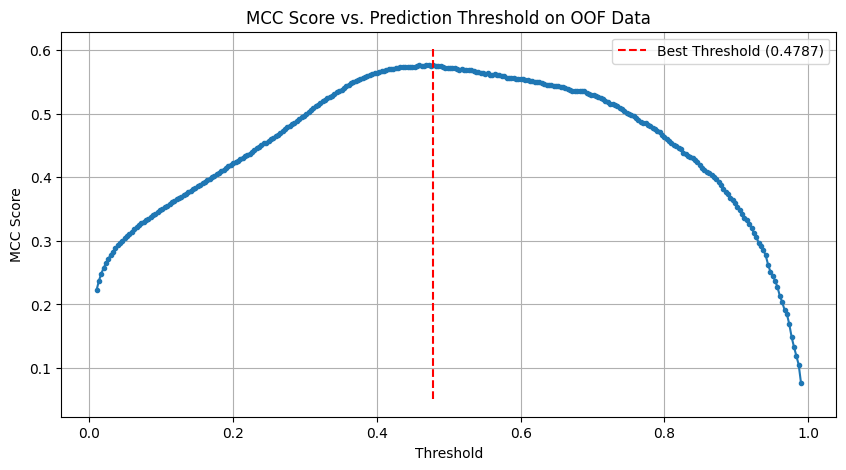

In [47]:
# Plot MCC vs Threshold (Optional) - menggunakan oof_preds_proba yang sudah diproses
plt.figure(figsize=(10, 5))
plt.plot(thresholds, mcc_scores, marker='.')
plt.title('MCC Score vs. Prediction Threshold on OOF Data')
plt.xlabel('Threshold')
plt.ylabel('MCC Score')
plt.vlines(best_threshold_mcc, plt.ylim()[0], plt.ylim()[1], color='red', linestyle='--', label=f'Best Threshold ({best_threshold_mcc:.4f})')
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix


Accuracy: 0.9910224475335471
Precision: 0.5672072872694957
Recall: 0.5948275862068966
F1-Score: 0.580689184578642
MCC: 0.5763207902901686


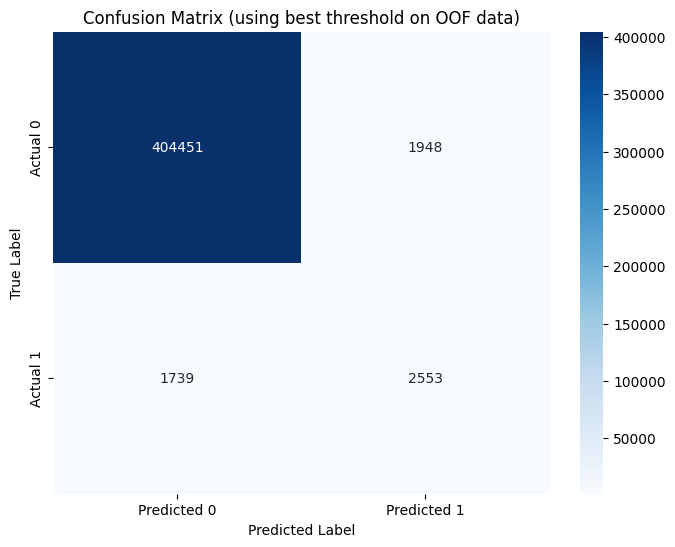

In [48]:
# Prediksi biner pada data training menggunakan best threshold (untuk confusion matrix)
oof_preds_binary_best_thresh = (oof_preds_proba >= best_threshold_mcc).astype(int)

# Buat Confusion Matrix
cm = confusion_matrix(y, oof_preds_binary_best_thresh) # y adalah target asli

# Hitung nilai-nilai
accuracy = accuracy_score(y, oof_preds_binary_best_thresh)
precision = precision_score(y, oof_preds_binary_best_thresh)
recall = recall_score(y, oof_preds_binary_best_thresh)
f1 = f1_score(y, oof_preds_binary_best_thresh)
mcc = matthews_corrcoef(y, oof_preds_binary_best_thresh)

# Tampilkan Confusion Matrix dan nilai-nilai
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("MCC:", mcc)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix (using best threshold on OOF data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### False Positives & Negatives

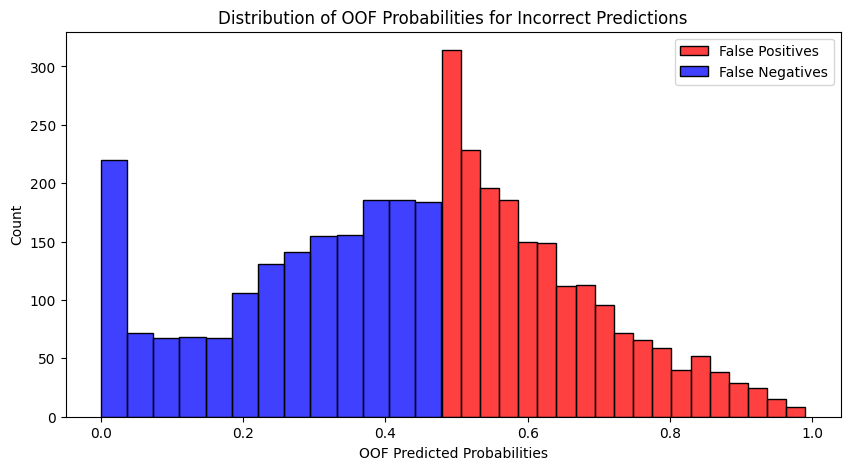

In [49]:
# Get incorrectly predicted indices
incorrect_indices = np.where(y != (oof_preds_proba >= best_threshold_mcc).astype(int))[0]

# Separate false positives and false negatives
false_positives = incorrect_indices[np.where(y[incorrect_indices] == 0)[0]]
false_negatives = incorrect_indices[np.where(y[incorrect_indices] == 1)[0]]

# Visualize the oof_preds_proba distribution for false positives and false negatives
plt.figure(figsize=(10, 5))
sns.histplot(oof_preds_proba[false_positives], label='False Positives', color='red')
sns.histplot(oof_preds_proba[false_negatives], label='False Negatives', color='blue')
plt.xlabel('OOF Predicted Probabilities')
plt.ylabel('Count')
plt.title('Distribution of OOF Probabilities for Incorrect Predictions')
plt.legend()
plt.show()

### SUBMISSION

In [50]:
#  Membuat File Submission

# Terapkan Threshold Terbaik pada Probabilitas Test
print(f"Applying best threshold ({best_threshold_mcc:.4f}) to test predictions...")
test_predictions_proba_raw = (lgbm_weight * lgbm_test_predictions_proba_raw +
                                xgb_weight * xgb_test_predictions_proba_raw +
                                cb_weight * cb_test_predictions_proba_raw)


test_predictions_binary = (test_predictions_proba_raw >= best_threshold_mcc).astype(int)


# Buat DataFrame submission
submission_df = pd.DataFrame({
    'id': test_merged['id'], # Ambil ID dari test_merged
    'is_referenced': test_predictions_binary
})

# Cek hasil submission
print("\n Submission File Head ")
display(submission_df.head())
print("\n Submission Value Counts ")
submission_df['is_referenced'].value_counts()

Applying best threshold (0.4787) to test predictions...

 Submission File Head 


,id,is_referenced
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0



 Submission Value Counts 


,count
is_referenced,
0,332785
1,3236


In [51]:
# Simpan ke CSV
output_filename = f'submission.csv'
submission_df.to_csv(output_filename, index=False)
print(f"\nSubmission file saved as {output_filename}")


Submission file saved as submission.csv


In [52]:
submission_df.to_csv(f'{base_path}/{output_filename}', index=False)